<a href="https://colab.research.google.com/github/MasRangga/OSR-FacialSkin/blob/main/Skin_Osr_Qcpn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import os
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_large
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, f1_score
import csv
import time
import PIL.Image
import random

# Set Random Seed

In [ ]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False)

set_random_seed()

# Load Dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
import os

# Unzip dataset
with ZipFile('/content/drive/MyDrive/Dataset/archieve_split.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
from zipfile import ZipFile
import os

# Unzip dataset
with ZipFile('/content/drive/MyDrive/Dataset/archive.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Data Augmentation

In [ ]:
from torchvision.transforms.autoaugment import RandAugment
from PIL import Image

# Definisikan path direktori asal dan tujuan
train_data_dir = '/content/skin-90/Training'  # Path asal dataset

# Membuat direktori baru untuk menyimpan hasil augmented jika belum ada
if not os.path.exists(train_data_dir):
    os.makedirs(train_data_dir)

# Rotasi acak antara -30° hingga +30°
augment_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-30, 30))
])


# Fungsi untuk melakukan augmentasi dan menyimpan gambar
def augment_and_save(image_path, save_path, num_augments=1):
    image = Image.open(image_path).convert("RGB")  # Buka gambar
    for i in range(num_augments):  # Lakukan augmentasi sebanyak num_augments kali
        augmented_image = augment_transform(image)  # Augmentasi gambar
        augmented_image.save(f"{save_path}_augmented_{i+1}.JPG")  # Simpan hasil augmentasi

# Loop melalui semua gambar di direktori train
for class_folder in os.listdir(train_data_dir):
    class_path = os.path.join(train_data_dir, class_folder)
    save_class_path = os.path.join(train_data_dir, class_folder)

    if not os.path.exists(save_class_path):
        os.makedirs(save_class_path)

    for img_file in os.listdir(class_path):
        # Proses hanya file dengan ekstensi JPG, JFIF, atau PNG
        if img_file.lower().endswith((".jpg", ".jfif", ".png")):
            img_path = os.path.join(class_path, img_file)
            base_filename = os.path.splitext(img_file)[0]
            save_img_path = os.path.join(save_class_path, base_filename)

            # Lakukan augmentasi dan simpan
            augment_and_save(img_path, save_img_path)

# Data Preparation

In [ ]:
def quad_channel_features(image, transform):
    angles = [0, 90, 180, 270]
    rotated_images = [transforms.functional.rotate(image, angle) for angle in angles]
    # Terapkan transform (Resize, ToTensor, Normalize) ke setiap gambar yang diputar
    transformed_rotated_images = [transform(img) for img in rotated_images]
    # Stack hasilnya. Dimensi akan menjadi (4, C, H, W)
    return torch.stack(transformed_rotated_images, dim=0)

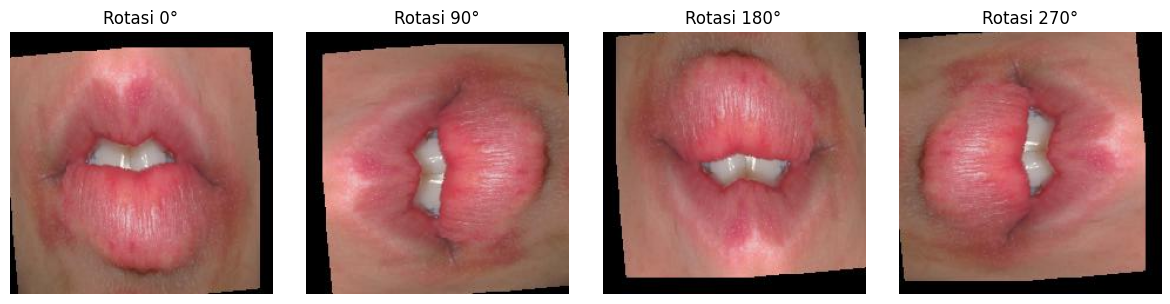

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Fungsi Anda
def quad_channel_features(image, transform):
    angles = [0, 90, 180, 270]
    rotated_images = [transforms.functional.rotate(image, angle) for angle in angles]
    transformed_rotated_images = [transform(img) for img in rotated_images]
    return torch.stack(transformed_rotated_images, dim=0), rotated_images

# Contoh transformasi (sesuaikan dengan model Anda)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load contoh gambar
image_path = '/content/Split Data/train_augmented/Dermatitis perioral/d10_aug57.jpg'  # Ganti dengan path gambar Anda
image = Image.open(image_path).convert('RGB')

# Panggil fungsi
features, rotated_images = quad_channel_features(image, transform)

# Tampilkan gambar hasil rotasi
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
angles = [0, 90, 180, 270]
for idx, (img, angle) in enumerate(zip(rotated_images, angles)):
    axs[idx].imshow(img)
    axs[idx].set_title(f'Rotasi {angle}°')
    axs[idx].axis('off')
plt.tight_layout()
plt.show()


## Data Preparation for OSR Task

In [ ]:
class OSRQuadChannelSkinDataset(Dataset):
    def __init__(self, root_dir, known_classes_names, unknown_classes_names, transform=None, is_train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train
        self.image_paths = []
        self.labels = []

        # Membuat pemetaan nama kelas known ke indeks label (0, 1, 2, ...)
        self.known_class_to_idx = {name: idx for idx, name in enumerate(sorted(known_classes_names))}
        # Kelas unknwon akan di beri label -1

        # Logging untuk debugging
        print(f"Initializing OSR dataset for root_dir: {root_dir}, is_train: {self.is_train}")
        print(f"Known classes being sought: {known_classes_names}")
        print(f"Unknown classes being sought: {unknown_classes_names}")
        print(f"Known class mapping: {self.known_class_to_idx}")

        # Variabel bantu untuk menghitung jumlah data yang ditemukan
        known_count_found = 0
        unknown_count_found = 0
        folders_found_in_root = []

        # Cek apakah direktori root tersedia
        if not os.path.exists(root_dir):
            print(f"Error: Root directory {root_dir} not found.")
            print("-" * 30)
            return # Keluar jika direktori root tidak ditemukan

        # Menelusuri seluruh folder (kelas) di dalam root_dir
        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                folders_found_in_root.append(class_name)
                # print(f"Checking folder: {class_name}") # Debugging

                # Jika folder adalah kelas yang diketahui (known)
                if class_name in self.known_class_to_idx:
                    for image_file in os.listdir(class_path):
                        if image_file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif")):
                            image_path = os.path.join(class_path, image_file)
                            # Known samples are included in both train and test datasets (for evaluation of known performance)
                            self.image_paths.append(image_path)
                            self.labels.append(self.known_class_to_idx[class_name])
                            known_count_found += 1
                            # print(f"  Found Known: {image_path}") # Debugging

               # Jika folder adalah kelas unknown DAN dataset sedang untuk testing (bukan training)
                elif class_name in unknown_classes_names and not self.is_train:
                    for image_file in os.listdir(class_path):
                         if image_file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif")):
                            image_path = os.path.join(class_path, image_file)
                            self.image_paths.append(image_path)
                            self.labels.append(-1) # Label for unknown class
                            unknown_count_found += 1
                            # print(f"  Found Unknown: {image_path}") # Debugging

        print(f"Folders found in {root_dir}: {folders_found_in_root}")
        print(f"Finished processing folders in {root_dir}. Found {known_count_found} known samples and {unknown_count_found} unknown samples for is_train={self.is_train}.")
        print(f"Total samples collected for dataset: {len(self.image_paths)}")

        if len(self.image_paths) == 0:
            print(f"WARNING: Dataset for {root_dir} is empty.")

        print("-" * 30) # Separator for dataset initializations


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = PIL.Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return placeholder for error handling
            if self.transform:
                dummy_image_single = torch.zeros(3, 224, 224)
                dummy_image_quad = torch.stack([dummy_image_single] * 4, dim=0)
            else:
                dummy_image_quad = torch.zeros(4, 1, 1, 1)
            return dummy_image_quad, -2 # Use -2 for loading errors


        if self.transform:
            quad_image_tensor = quad_channel_features(image, self.transform)
        else:
            angles = [0, 90, 180, 270]
            rotated_images = [transforms.functional.rotate(image, angle) for angle in angles]
            quad_image_tensor = torch.stack([transforms.ToTensor()(img) for img in rotated_images], dim=0)

        return quad_image_tensor, label

# Feature Extraction Function

In [ ]:
def extract_quad_features(model, dataloader, device, output_file):
    model.eval()
    features, labels = [], []

    print(f"Starting feature extraction for {len(dataloader.dataset)} samples...")
    processed_samples = 0
    with torch.no_grad():
        for images, lbls in dataloader:
            # Filter out invalid samples if any (-1 label)
            valid_indices = [i for i, label in enumerate(lbls) if label != -2]
            if not valid_indices:
                print("Skipping batch with only invalid samples.")
                continue

            images = images[valid_indices]
            lbls = lbls[valid_indices]

            if images.size(0) == 0:
                print("Skipping batch after filtering invalid samples.")
                continue

            batch_features = []
            lbls = lbls.to(device)

            for i in range(4):  # Process each channel (each rotation)
                # Ambil channel ke-i dari batch. Shape: (batch_size, C, H, W)
                channel_images = images[:, i, :, :, :].to(device)
                if channel_images.size(1) != 3:
                     print(f"Warning: Expected 3 channels for feature extraction, but got {channel_images.size(1)}. Skipping batch.")
                     continue

                channel_features = model(channel_images).cpu().numpy()
                batch_features.append(channel_features)

            # Concatenate features from the 4 rotations for each image sample
            # Shape: (batch_size, 4 * feature_dim_from_mobilenet)
            if len(batch_features) == 4: # Pastikan fitur dari 4 channel berhasil diekstraksi
                 batch_features = np.concatenate(batch_features, axis=1)
                 features.append(batch_features)
                 labels.append(lbls.cpu().numpy())
                 processed_samples += images.size(0)
            else:
                 print(f"Warning: Could not extract features from all 4 channels for a batch. Skipping batch.")


    # Pastikan ada fitur yang berhasil diekstraksi sebelum concatenating
    if len(features) > 0 and len(labels) > 0:
        features = np.concatenate(features, axis=0)
        labels = np.concatenate(labels, axis=0)

        # Simpan fitur dan label ke file pickle
        with open(output_file, 'wb') as f:
            pickle.dump((features, labels), f)

        print(f"Quad-channel features for {processed_samples} samples saved to {output_file}")
    else:
        print("No valid features extracted. Output file not created.")


# Build QC-CPN

In [ ]:
class QC_CPN(nn.Module):
    def __init__(self, feature_dim, num_classes, gamma=0.1, epsilon=0.5,
                 hidden_size1=None, hidden_size2=None, activation_function='relu'):
        super(QC_CPN, self).__init__()

        self.feature_dim = feature_dim
        self.num_classes = num_classes
        self.gamma = gamma  # Skala logits untuk cross-entropy
        self.epsilon = epsilon  # Margin untuk contrastive loss

        # Mapping fungsi aktivasi yang didukung
        self.activation_dict = {
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'leakyrelu': nn.LeakyReLU(),
            'elu': nn.ELU()
        }

        self.hidden_layer1 = None
        self.hidden_layer2 = None
        self.activation = None

        # Setup hidden layer sesuai input
        if hidden_size1 is not None and hidden_size2 is not None:
            # Dua hidden layer
            self.hidden_layer1 = nn.Linear(feature_dim, hidden_size1)
            self.hidden_layer2 = nn.Linear(hidden_size1, hidden_size2)
            self.activation = self.activation_dict.get(activation_function.lower())
            self.prototype_feature_dim = hidden_size2
        elif hidden_size1 is not None:
            # Satu hidden layer
            self.hidden_layer1 = nn.Linear(feature_dim, hidden_size1)
            self.activation = self.activation_dict.get(activation_function.lower())
            self.prototype_feature_dim = hidden_size1
        else:
            # Tanpa hidden layer
            self.prototype_feature_dim = feature_dim

        # Prototype yang akan dipelajari model (1 prototype per kelas)
        self.prototypes = nn.Parameter(torch.randn(num_classes, self.prototype_feature_dim))

    def forward(self, features):
        # Proses hidden layer jika ada
        if self.hidden_layer1 is not None:
            features = self.activation(self.hidden_layer1(features))
            if self.hidden_layer2 is not None:
                features = self.activation(self.hidden_layer2(features))

        # Hitung jarak fitur ke setiap prototype
        distances = torch.cdist(features, self.prototypes)

        # Return negatif jarak agar jarak kecil jadi logits besar
        return -distances

    def contrastive_loss(self, features, labels, w1=1.0):
        # Proses hidden layer jika ada
        if self.hidden_layer1 is not None:
            features = self.activation(self.hidden_layer1(features))
            if self.hidden_layer2 is not None:
                features = self.activation(self.hidden_layer2(features))

        # Hitung jarak ke semua prototypes
        distances = torch.cdist(features, self.prototypes)

        # Hitung cross entropy dari negatif jarak yang di-skala
        ce_loss = F.cross_entropy(self.gamma * -distances, labels)

        # Hitung jarak positif (ke prototype label benar)
        batch_size = features.size(0)
        positive_distances = distances[torch.arange(batch_size), labels]

        # Hitung jarak negatif (ke prototype terdekat kelas lain)
        positive_mask = torch.zeros_like(distances, dtype=torch.bool)
        positive_mask[torch.arange(batch_size), labels] = True
        negative_distances = torch.min(distances.masked_fill(positive_mask, float('inf')), dim=1)[0]

        # Contrastive loss dengan margin
        contrastive = torch.clamp(self.gamma + self.epsilon * positive_distances - negative_distances, min=0).mean()

        # Gabungkan cross entropy + contrastive loss
        return ce_loss + w1 * contrastive


# Model Training and Evaluate

## Training and Evaluate Model Function with OSR unknown vs known

In [ ]:
def evaluate_model_OSR(model, dataloader, device, num_known_classes, threshold=0.6):
    model.eval()  # Set model ke mode evaluasi
    total_loss, total_correct_known = 0, 0

    all_true_labels = []  # Untuk metrik klasifikasi (hanya kelas known)
    all_predicted_labels = []
    all_is_known_labels = []  # Label biner: 1 = known, 0 = unknown
    all_confidence_scores = []  # Skor kepercayaan (confidence) untuk prediksi known vs unknown
    all_predicted_is_known = []  # Prediksi known/unknown berdasarkan threshold  # Prediksi known/unknown berdasarkan threshold

    print(f"Starting OSR evaluation for {len(dataloader.dataset)} samples...")
    processed_samples = 0  # Total jumlah sampel known yang diproses

    with torch.no_grad():
        for features, labels in dataloader:
            # Saring sampel yang tidak valid (label = -2, error saat load gambar)
            valid_indices = [i for i, label in enumerate(labels) if label != -2]
            if not valid_indices:
                continue

            features_valid = features[valid_indices].to(device)
            labels_valid = labels[valid_indices].to(device)

            if features_valid.size(0) == 0:
                continue

            # Output model berupa jarak negatif terhadap prototipe kelas known
            outputs = model(features_valid)

            # Ubah jarak negatif menjadi similarity positif, lalu ke softmax
            similarities = -outputs
            softmax_scores = F.softmax(similarities, dim=1)
            confidence_scores = torch.max(softmax_scores, dim=1)[0]  # Skor confidence tertinggi

            # Simpan skor dan label biner (1 = known, 0 = unknown)
            all_confidence_scores.append(confidence_scores.cpu().numpy())
            is_known_labels = (labels_valid != -1).long()
            all_is_known_labels.append(is_known_labels.cpu().numpy())

            # Prediksi known/unknown berdasarkan threshold ---
            predicted_is_known = (confidence_scores >= threshold).long().cpu().numpy()
            all_predicted_is_known.append(predicted_is_known)

            # Ambil hanya sampel yang merupakan known class (label != -1)
            known_sample_indices_in_batch = (labels_valid != -1).nonzero(as_tuple=True)[0]

            if known_sample_indices_in_batch.size(0) > 0:
                known_features_batch = features_valid[known_sample_indices_in_batch]
                known_labels_batch = labels_valid[known_sample_indices_in_batch]
                known_outputs_batch = outputs[known_sample_indices_in_batch]

                predictions_known = torch.argmax(known_outputs_batch, dim=1)

                # Cek label agar tidak melebihi jumlah kelas known
                if known_labels_batch.max() < num_known_classes:
                    loss = model.contrastive_loss(known_features_batch, known_labels_batch)
                    total_loss += loss.item() * known_features_batch.size(0)
                else:
                    print(f"Warning: Found label index {known_labels_batch.max().item()} >= num_known_classes {num_known_classes} in batch.")

                # Akumulasi metrik klasifikasi untuk sampel known
                total_correct_known += (predictions_known == known_labels_batch).sum().item()
                all_true_labels.append(known_labels_batch.cpu().numpy())
                all_predicted_labels.append(predictions_known.cpu().numpy())
                processed_samples += known_features_batch.size(0)

    # Jika tidak ada data valid, keluar lebih awal
    if processed_samples == 0 and len(all_is_known_labels) == 0:
        print("Warning: No valid samples processed in evaluate_model_OSR.")
        return 0, 0, 0, 0, 0

    # Gabungkan semua data dari batch
    concatenated_true_labels = np.concatenate(all_true_labels, axis=0) if all_true_labels else np.array([])
    concatenated_predicted_labels = np.concatenate(all_predicted_labels, axis=0) if all_predicted_labels else np.array([])
    concatenated_is_known_labels = np.concatenate(all_is_known_labels, axis=0)
    concatenated_confidence_scores = np.concatenate(all_confidence_scores, axis=0)
    concatenated_predicted_is_known = np.concatenate(all_predicted_is_known, axis=0)

    # Perhitungan metrik klasifikasi (hanya untuk kelas known)
    val_acc_known = 0.0
    val_f1_known = 0.0
    val_loss_known = 0.0
    if processed_samples > 0:
        val_loss_known = total_loss / processed_samples
        val_acc_known = total_correct_known / processed_samples
        if len(concatenated_true_labels) > 0 and len(np.unique(concatenated_true_labels)) > 1:
            val_f1_known = f1_score(concatenated_true_labels, concatenated_predicted_labels, average='macro')

    # Perhitungan AUROC untuk OSR (binary: known vs unknown)
    val_auroc_osr = 0.0
    if len(np.unique(concatenated_is_known_labels)) == 2:
        try:
            val_auroc_osr = roc_auc_score(concatenated_is_known_labels, concatenated_confidence_scores)
        except ValueError as e:
            print(f"Error calculating AUROC: {e}")
            val_auroc_osr = 0.0
    else:
        print("Warning: Not enough known and unknown samples to calculate OSR AUROC.")
        val_auroc_osr = 0.0

    # --- Tambahan: Print ringkasan prediksi threshold ---
    if len(concatenated_predicted_is_known) > 0:
        n_known_pred = (concatenated_predicted_is_known == 1).sum()
        n_unknown_pred = (concatenated_predicted_is_known == 0).sum()
        print(f"Threshold {threshold}: Predicted Known={n_known_pred}, Predicted Unknown={n_unknown_pred}")
    # ---------------------------------------------------

    return val_loss_known, val_acc_known, val_f1_known, val_auroc_osr, processed_samples

In [ ]:
def train_model_OSR(model, train_loader, val_loader, optimizer, device, num_epochs, output_csv, num_known_classes):
    # Both train_loader and val_loader should provide pre-extracted features (shape: batch_size, feature_dim)
    results = []

    # Write header only if the file does not exist or is empty
    write_header = not os.path.exists(output_csv) or os.stat(output_csv).st_size == 0
    with open(output_csv, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Update header for OSR metrics
        if write_header:
            writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy (Known)', 'Train F1-Score (Known)',
                             'Val Loss (Known)', 'Val Accuracy (Known)', 'Val F1-Score (Known)', 'Val AUROC (Known vs Unknown)', 'Time'])

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()

        total_loss_train, total_correct_train = 0, 0
        all_train_labels, all_train_preds = [], []
        train_samples_processed = 0

        # Train Loop (using feature_loader - only known samples)
        print(f"Epoch {epoch+1}/{num_epochs} - Training...")
        for features, labels in train_loader:
             # Train loader should only contain known samples, but let's be safe
            valid_indices = [i for i, label in enumerate(labels) if label != -1 and label != -2]
            if not valid_indices:
                 # print("Skipping training batch with only invalid or unknown samples.") # Less verbose
                 continue

            features = features[valid_indices].to(device)
            labels = labels[valid_indices].to(device)

            if features.size(0) == 0:
                 # print("Skipping training batch after filtering invalid samples.") # Less verbose
                 continue

            optimizer.zero_grad()
            outputs = model(features) # outputs are negative distances
            predictions = torch.argmax(outputs, dim=1)

            # Contrastive loss is calculated only on known samples
            # Ensure labels for loss calculation are within the range of known classes
            if labels.max() < num_known_classes:
                 loss = model.contrastive_loss(features, labels)
                 loss.backward()
                 optimizer.step()

                 total_loss_train += loss.item() * features.size(0)
                 total_correct_train += (predictions == labels).sum().item()
                 all_train_labels.append(labels.cpu().numpy())
                 all_train_preds.append(predictions.cpu().numpy())
                 train_samples_processed += features.size(0)
            else:
                 print(f"Warning: Found label index {labels.max().item()} >= num_known_classes {num_known_classes} in training batch. Skipping loss calculation for this batch.")
                 # Still count correct predictions if possible, but loss is more important for train metric
                 # total_correct_train += (predictions == labels).sum().item() # Only count if you're sure labels are valid for prediction, but let's skip for simplicity here as loss is the primary train metric
                 # train_samples_processed += features.size(0) # Still count samples processed


        # Hitung metrik pelatihan hanya jika ada sampel yang diproses
        train_loss = 0.0
        train_acc = 0.0
        train_f1 = 0.0
        if train_samples_processed > 0:
            train_loss = total_loss_train / train_samples_processed
            train_acc = total_correct_train / train_samples_processed
            if len(np.concatenate(all_train_labels)) > 0 and len(np.unique(np.concatenate(all_train_labels))) > 1:
                 train_f1 = f1_score(np.concatenate(all_train_labels), np.concatenate(all_train_preds), average='macro')
            # else: F1 remains 0.0


        # Validation Phase (using validation feature loader - contains known and unknown)
        print(f"Epoch {epoch+1}/{num_epochs} - Validating (OSR)...")
        val_loss_known, val_acc_known, val_f1_known, val_auroc_osr, _ = evaluate_model_OSR(model, val_loader, device, num_known_classes)

        epoch_time = time.time() - start_time

        # Log results (update columns to match new header)
        results_row = [epoch + 1, train_loss, train_acc, train_f1,
                       val_loss_known, val_acc_known, val_f1_known, val_auroc_osr, epoch_time]
        results.append(results_row)

        # Append results to CSV
        with open(output_csv, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(results_row)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Train Acc (Known)={train_acc:.4f}, Train F1 (Known)={train_f1:.4f}, "
              f"Val Loss (Known)={val_loss_known:.4f}, Val Acc (Known)={val_acc_known:.4f}, Val F1 (Known)={val_f1_known:.4f}, Val AUROC (Known vs Unknown)={val_auroc_osr:.4f}, Time={epoch_time:.2f}s")

# Path Setting

In [ ]:
train_data_root = "/content/Split Data/train_augmented"
test_data_root = "/content/skin-90/Test"
train_feature_output_file = "quad_train_features.pkl"
test_feature_output_file = "quad_test_features.pkl"
csv_output_file = "training_results.csv"

# Data Preparation for OSR Task

## Pembagian kelas diketahui dan tidak diketahui

In [ ]:
data_root_directory = "/content/skin-90/Test"
all_class_names = [d for d in os.listdir(data_root_directory) if os.path.isdir(os.path.join(data_root_directory, d))]
print(f"Semua kelas yang ditemukan: {all_class_names}")
print(f"Jumlah total kelas: {len(all_class_names)}")

percentage_known = 0.60
num_known_classes_to_select = int(len(all_class_names) * percentage_known)

if len(all_class_names) > 0 and num_known_classes_to_select == 0:
    num_known_classes_to_select = 1

random.shuffle(all_class_names)

# Bagi menjadi kelas yang diketahui dan tidak diketahui
known_classes_names = all_class_names[:num_known_classes_to_select]
unknown_classes_names = all_class_names[num_known_classes_to_select:]

print("-" * 30)
print(f"Jumlah kelas diketahui yang dipilih secara random ({percentage_known*100}%): {len(known_classes_names)}")
print(f"Kelas diketahui yang dipilih: {known_classes_names}")
print("-" * 30)
print(f"Jumlah kelas tidak diketahui yang dipilih: {len(unknown_classes_names)}")
print(f"Kelas tidak diketahui yang dipilih: {unknown_classes_names}")

Semua kelas yang ditemukan: ['fungal acne', 'Eksim', 'Karsinoma', 'kutil filiform', 'milia', 'acne nodules', 'flek hitam', 'melanoma', 'whitehead', 'herpes', 'Dermatitis perioral', 'psoriasis', 'rosacea', 'folikulitis', 'papula', 'Pustula', 'panu', 'acne fulminans', 'blackhead', 'Tinea facialis']
Jumlah total kelas: 20
------------------------------
Jumlah kelas diketahui yang dipilih secara random (60.0%): 12
Kelas diketahui yang dipilih: ['Tinea facialis', 'acne nodules', 'papula', 'milia', 'herpes', 'folikulitis', 'Pustula', 'blackhead', 'flek hitam', 'rosacea', 'acne fulminans', 'Dermatitis perioral']
------------------------------
Jumlah kelas tidak diketahui yang dipilih: 8
Kelas tidak diketahui yang dipilih: ['Eksim', 'psoriasis', 'Karsinoma', 'panu', 'melanoma', 'whitehead', 'fungal acne', 'kutil filiform']


In [ ]:
known_class_to_idx = {name: idx for idx, name in enumerate(sorted(known_classes_names))}
unknown_class_to_idx = {name: -1 for name in unknown_classes_names} # Gunakan -1 atau nilai khusus untuk kelas tidak diketahui

## Load Dataset to Data Loader

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets that provide quad-channel *images* (ready for feature extraction)
train_dataset_images = OSRQuadChannelSkinDataset(
    root_dir=train_data_root,
    known_classes_names=known_classes_names, # Provide the list of known class names
    unknown_classes_names=unknown_classes_names, # Provide the list of unknown class names
    transform=transform,
    is_train=True # Set to True for the training dataset
)
# Use shuffle=False for feature extraction loaders to ensure order is consistent with labels
train_loader_images = DataLoader(train_dataset_images, batch_size=16, shuffle=False)

test_dataset_images = OSRQuadChannelSkinDataset(
    root_dir=test_data_root,
    known_classes_names=known_classes_names, # Provide the list of known class names
    unknown_classes_names=unknown_classes_names, # Provide the list of unknown class names
    transform=transform,
    is_train=False # Set to False for the test/evaluation dataset
)
test_loader_images = DataLoader(test_dataset_images, batch_size=16, shuffle=False)

Initializing OSR dataset for root_dir: /content/Split Data/train_augmented, is_train: True
Known classes being sought: ['Tinea facialis', 'acne nodules', 'papula', 'milia', 'herpes', 'folikulitis', 'Pustula', 'blackhead', 'flek hitam', 'rosacea', 'acne fulminans', 'Dermatitis perioral']
Unknown classes being sought: ['Eksim', 'psoriasis', 'Karsinoma', 'panu', 'melanoma', 'whitehead', 'fungal acne', 'kutil filiform']
Known class mapping: {'Dermatitis perioral': 0, 'Pustula': 1, 'Tinea facialis': 2, 'acne fulminans': 3, 'acne nodules': 4, 'blackhead': 5, 'flek hitam': 6, 'folikulitis': 7, 'herpes': 8, 'milia': 9, 'papula': 10, 'rosacea': 11}
Folders found in /content/Split Data/train_augmented: ['fungal acne', 'Eksim', 'Karsinoma', 'kutil filiform', 'milia', 'acne nodules', 'flek hitam', 'melanoma', 'whitehead', 'herpes', 'Dermatitis perioral', 'psoriasis', 'rosacea', 'folikulitis', 'papula', 'Pustula', 'panu', 'acne fulminans', 'blackhead', 'Tinea facialis']
Finished processing folders 

# tes

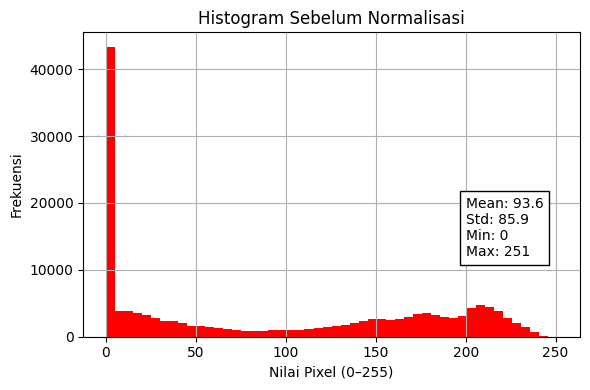

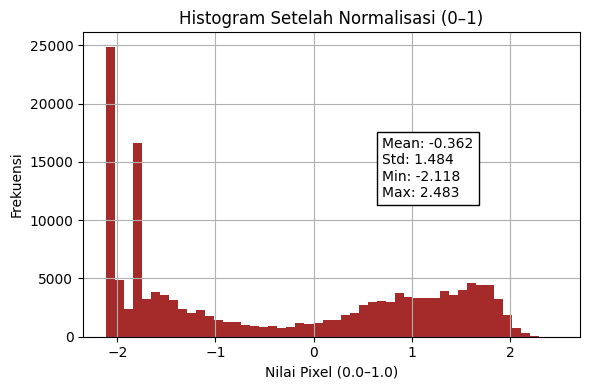

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Ganti path ini dengan path menuju salah satu gambar dari datasetmu
image_path = "/content/Split Data/train_augmented/herpes/h31_aug36.jpg"  # Ganti sesuai path gambar

# Load gambar
image = Image.open(image_path).convert("RGB")

# Konversi ke array numpy
image_np = np.array(image)  # shape (H, W, 3), nilai 0–255

# --- Histogram sebelum normalisasi ---
plt.figure(figsize=(6, 4))
plt.hist(image_np.ravel(), bins=50, color='red')
plt.title("Histogram Sebelum Normalisasi")
plt.xlabel("Nilai Pixel (0–255)")
plt.ylabel("Frekuensi")
plt.grid(True)

# Hitung statistik
mean_val = np.mean(image_np)
std_val = np.std(image_np)
min_val = np.min(image_np)
max_val = np.max(image_np)

# Tambahkan kotak statistik
stats_text = f"Mean: {mean_val:.1f}\nStd: {std_val:.1f}\nMin: {min_val}\nMax: {max_val}"
plt.text(200, 12000, stats_text, bbox=dict(facecolor='white', edgecolor='black'))

plt.tight_layout()
plt.show()

# --- Histogram setelah normalisasi ---
transform = transforms.Compose([
    transforms.ToTensor(),  # Normalisasi 0–1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

normalized_tensor = transform(image)  # shape: (3, H, W)
normalized_np = normalized_tensor.numpy().transpose(1, 2, 0).ravel()

plt.figure(figsize=(6, 4))
plt.hist(normalized_np, bins=50, color='brown')
plt.title("Histogram Setelah Normalisasi (0–1)")
plt.xlabel("Nilai Pixel (0.0–1.0)")
plt.ylabel("Frekuensi")
plt.grid(True)

# Hitung statistik pasca normalisasi
mean_norm = np.mean(normalized_np)
std_norm = np.std(normalized_np)
min_norm = np.min(normalized_np)
max_norm = np.max(normalized_np)

stats_text_norm = f"Mean: {mean_norm:.3f}\nStd: {std_norm:.3f}\nMin: {min_norm:.3f}\nMax: {max_norm:.3f}"
plt.text(0.7, 12000, stats_text_norm, bbox=dict(facecolor='white', edgecolor='black'))

plt.tight_layout()
plt.show()


## Unknown & Known Classes Checking

In [ ]:
known_classes_list = list(train_dataset_images.known_class_to_idx.keys())
print(f"Kelas yang diketahui: {known_classes_list}")
num_known_classes = len(known_classes_list)
print(f"Jumlah kelas diketahui: {num_known_classes}")

# You can also print the unknown classes list if needed
print(f"Kelas yang tidak diketahui: {unknown_classes_names}")
num_unknown_classes = len(unknown_classes_names)
print(f"Jumlah kelas tidak diketahui: {num_unknown_classes}")

# If you need the total number of classes available in the original dataset structure,
# you might need to reconstruct it or access it differently if OSRDataset stored it.
# Assuming the sum of known and unknown classes you defined is the "total" for this context:
num_total_classes_defined = num_known_classes + num_unknown_classes
print(f"Jumlah total kelas (gabungan diketahui + tidak diketahui): {num_total_classes_defined}")

Kelas yang diketahui: ['Karsinoma', 'Pustula', 'acne fulminans', 'acne nodules', 'blackhead', 'flek hitam', 'fungal acne', 'melanoma', 'panu', 'psoriasis', 'rosacea', 'whitehead']
Jumlah kelas diketahui: 12
Kelas yang tidak diketahui: ['milia', 'kutil filiform', 'Tinea facialis', 'Eksim', 'herpes', 'Dermatitis perioral', 'papula', 'folikulitis']
Jumlah kelas tidak diketahui: 8
Jumlah total kelas (gabungan diketahui + tidak diketahui): 20


# Load Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SMALL

In [ ]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# Step 1: Feature Extraction
weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1  # versi pretrained weights
mobilenet = mobilenet_v3_small(weights=weights)
mobilenet.classifier = nn.Identity()
mobilenet = mobilenet.to(device)

# Weight Freez
for param in mobilenet.parameters():
    param.requires_grad = False


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 97.4MB/s]


# LARGE

In [ ]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
import torch.nn as nn

# Step 1: Feature Extraction
weights = MobileNet_V3_Large_Weights.IMAGENET1K_V2  # versi V2 pretrained weights
mobilenet = mobilenet_v3_large(weights=weights)

# Hapus layer klasifikasi terakhir untuk keperluan feature extraction
mobilenet.classifier = nn.Identity()

# Pindahkan model ke device (misal CUDA atau CPU)
mobilenet = mobilenet.to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 116MB/s] 


# Feature Extraction

In [ ]:
extract_quad_features(mobilenet, train_loader_images, device, train_feature_output_file)
extract_quad_features(mobilenet, test_loader_images, device, test_feature_output_file)

Starting feature extraction for 1800 samples...
Quad-channel features for 1800 samples saved to quad_train_features.pkl
Starting feature extraction for 127 samples...
Quad-channel features for 127 samples saved to quad_test_features.pkl


# Hasil ekstraksi

In [ ]:
import pickle

with open("/content/quad_train_features.pkl", "rb") as f:
    data = pickle.load(f)

# Lihat tipe dan contoh isi
print(type(data))
print(data.keys() if isinstance(data, dict) else data[:1])


<class 'tuple'>
(array([[ 0.2437961 ,  0.01066114, -0.06323776, ...,  0.21900254,
         0.10935756,  0.33500993],
       [ 0.157491  , -0.07695264,  0.27701825, ...,  0.590246  ,
         0.00213606, -0.13744271],
       [ 0.48533082, -0.10169695,  0.08657835, ...,  0.40817723,
         0.43812567,  0.0316764 ],
       ...,
       [-0.10768957, -0.0047243 ,  0.0231191 , ...,  0.06996121,
        -0.24834563, -0.20376377],
       [-0.0161741 ,  0.17763838, -0.05400949, ...,  0.21976894,
        -0.16464312,  0.03147532],
       [-0.14482272, -0.10515776, -0.14282444, ..., -0.10133211,
        -0.18408382, -0.16040725]], dtype=float32),)


# Load Pickle Feature

In [ ]:
with open(train_feature_output_file, 'rb') as f:
    train_features, train_labels = pickle.load(f)

In [ ]:
# Create DataLoader for training features
train_feature_dataset = torch.utils.data.TensorDataset(torch.tensor(train_features, dtype=torch.float32),
                                                  torch.tensor(train_labels, dtype=torch.long))
# Shuffle=True for training loader
train_feature_loader = DataLoader(train_feature_dataset, batch_size=16, shuffle=True)


In [ ]:
with open(test_feature_output_file, 'rb') as f:
    test_features, test_labels = pickle.load(f)

In [ ]:
test_feature_dataset = torch.utils.data.TensorDataset(torch.tensor(test_features, dtype=torch.float32),
                                                 torch.tensor(test_labels, dtype=torch.long))
# Shuffle=False for validation loader is typical
test_feature_loader = DataLoader(test_feature_dataset, batch_size=16, shuffle=False)


# Rumusan Masalah 1: Konfigurasi Lapisan Tersembunyi

# 512 Neuron

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = None
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.5
QC_CPN_EPSILON = 50

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="testestrain_result_512_neuron.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
Threshold 0.6: Predicted Known=0, Predicted Unknown=127
Epoch 1/50: Train Loss=991.5206, Train Acc (Known)=0.6228, Train F1 (Known)=0.6166, Val Loss (Known)=1001.0152, Val Acc (Known)=0.4557, Val F1 (Known)=0.4805, Val AUROC (Known vs Unknown)=0.4565, Time=1.27s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
Threshold 0.6: Predicted Known=1, Predicted Unknown=126
Epoch 2/50: Train Loss=875.0488, Train Acc (Known)=0.8894, Train F1 (Known)=0.8877, Val Loss (Known)=926.2602, Val Acc (Known)=0.5316, Val F1 (Known)=0.5296, Val AUROC (Known vs Unknown)=0.3576, Time=0.42s
Epoch 3/50 - Training...
Epoch 3/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
Threshold 0.6: Predicted Known=0, Predicted Unknown=127
Epoch 3/50: Train Loss=795.2416, Train Acc (Known)=0.9467, Train F1 (Known)=0.9471, Val 

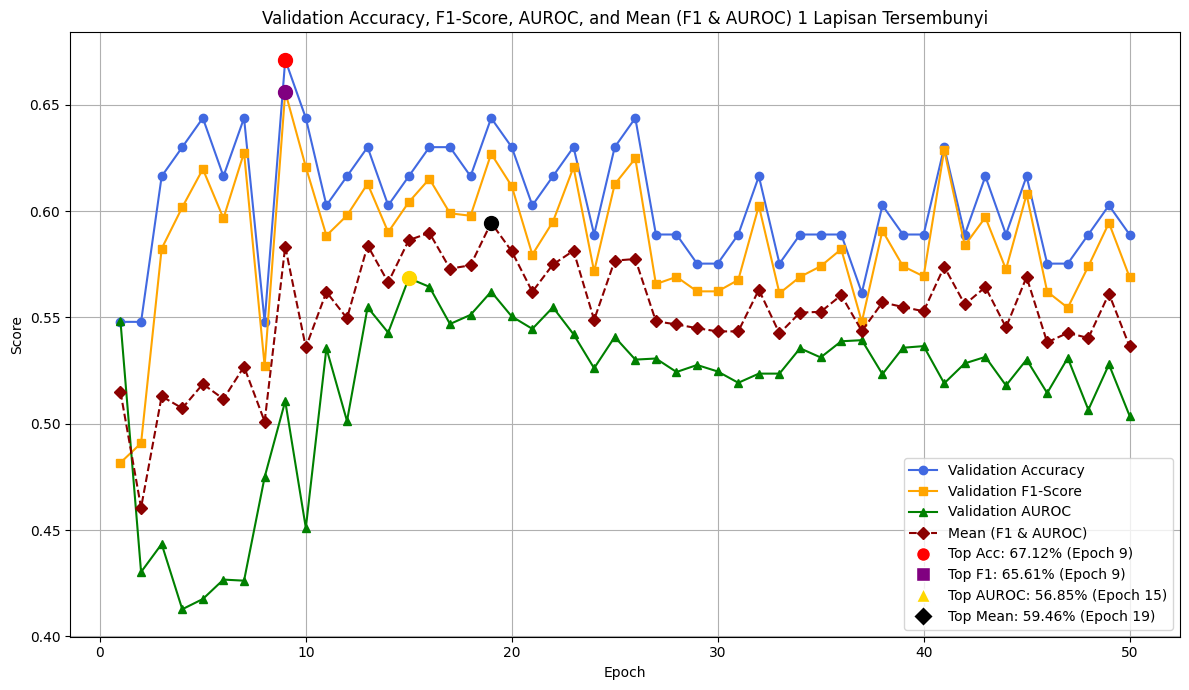

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    # Baca file CSV
    df_results = pd.read_csv('/content/small_train_result_512_neuron.csv')

    # Hitung mean F1 dan AUROC dalam skala desimal
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    # Plot
    plt.figure(figsize=(12, 7))

    # Plot metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Ambil titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']

    # Tambahkan scatter
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w',
               label=f'Top Acc: {acc_val * 100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w',
               label=f'Top F1: {f1_val * 100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w',
               label=f'Top AUROC: {auroc_val * 100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w',
               label=f'Top Mean: {mean_val * 100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Format plot
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC) 1 Lapisan Tersembunyi')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


In [ ]:
epoch = 19  # Misalnya dari grafik
row = df_results[df_results['Epoch'] == epoch]
print(row[['Val F1-Score (Known)', 'Val AUROC (Known vs Unknown)']])
mean_val = (row['Val F1-Score (Known)'].values[0] + row['Val AUROC (Known vs Unknown)'].values[0]) / 2
print(f"Mean F1 & AUROC di epoch {epoch}: {mean_val * 100:.2f}%")

    Val F1-Score (Known)  Val AUROC (Known vs Unknown)
18              0.627025                      0.562151
Mean F1 & AUROC di epoch 19: 59.46%


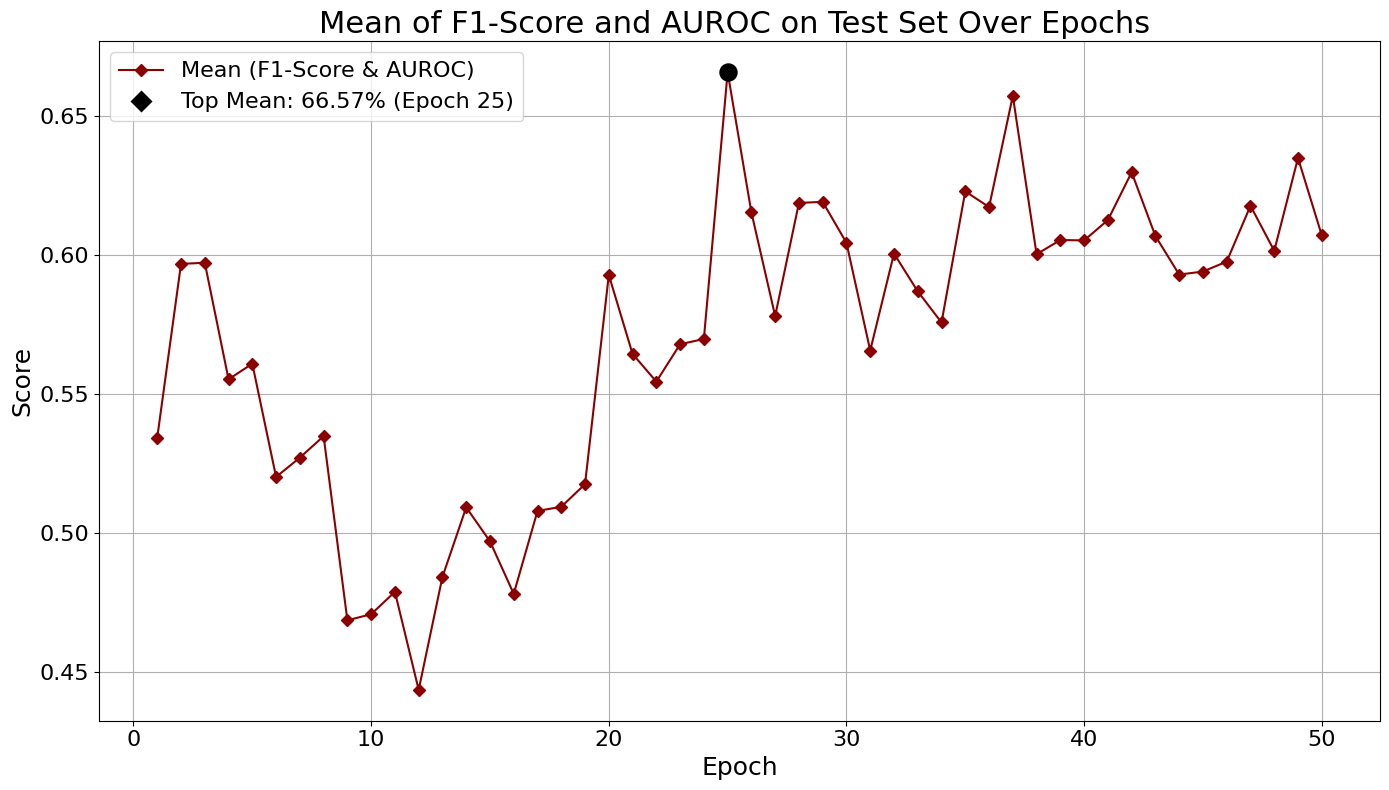

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_epsilon60.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(14, 8))  # Tambah sedikit ukuran figure

    # Plot hanya 1 garis: mean dari F1 dan AUROC
    mean_line, = plt.plot(
        df_results['Epoch'],
        df_results['Mean F1-AUROC'],
        marker='D',
        label='Mean (F1-Score & AUROC)',
        color='darkred',
        linestyle='-'
    )

    # Titik tertinggi dari mean
    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=150, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='D', color='w',
               label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=12)
    ]

    # Perbesar font
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Score', fontsize=18)
    plt.title('Mean of F1-Score and AUROC on Test Set Over Epochs ', fontsize=22)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.legend(handles=[mean_line] + custom_legend, fontsize=16)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


# 512 512 Neuron

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.5
QC_CPN_EPSILON = 50

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="small_train_result_512_512_neuron.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1548, Max: 0.4394, Mean: 0.2603, Std: 0.0648
Confidence scores (Unknown) - Min: 0.1589, Max: 0.4213, Mean: 0.2461, Std: 0.0650
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=1003.9528, Train Acc (Known)=0.5244, Train F1 (Known)=0.5183, Val Loss (Known)=968.4361, Val Acc (Known)=0.5753, Val F1 (Known)=0.4994, Val AUROC (Known vs Unknown)=0.5827, Time=0.44s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1698, Max: 0.4912, Mea

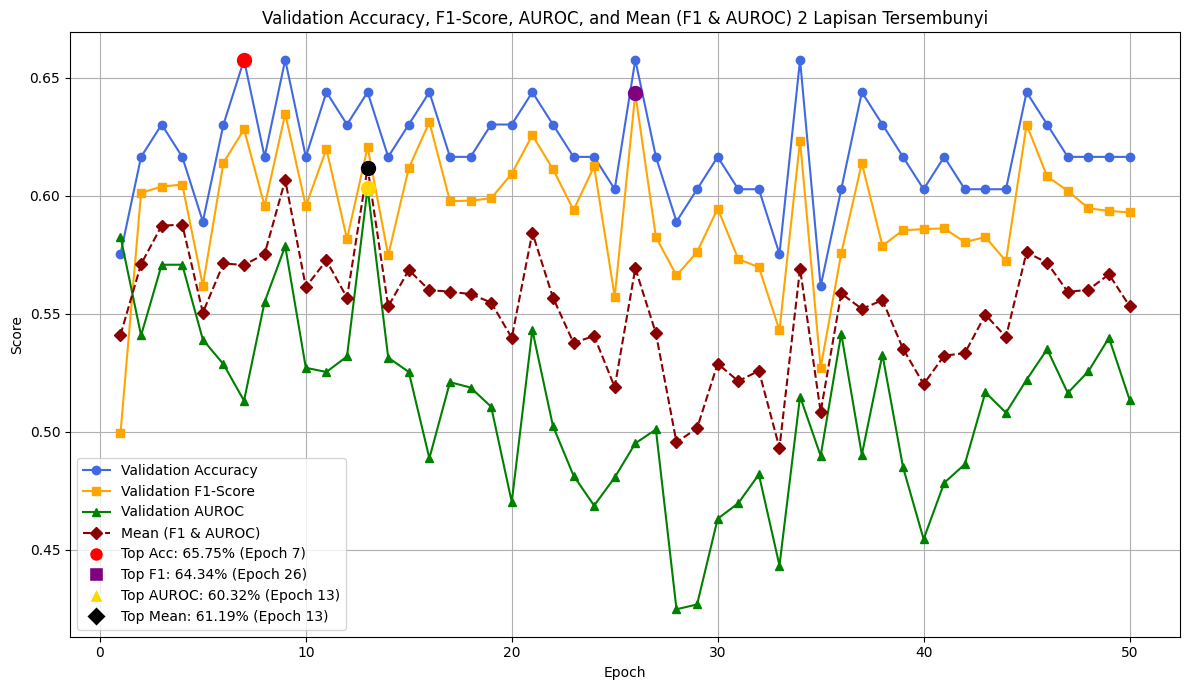

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/small_train_result_512_512_neuron.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC) 2 Lapisan Tersembunyi')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


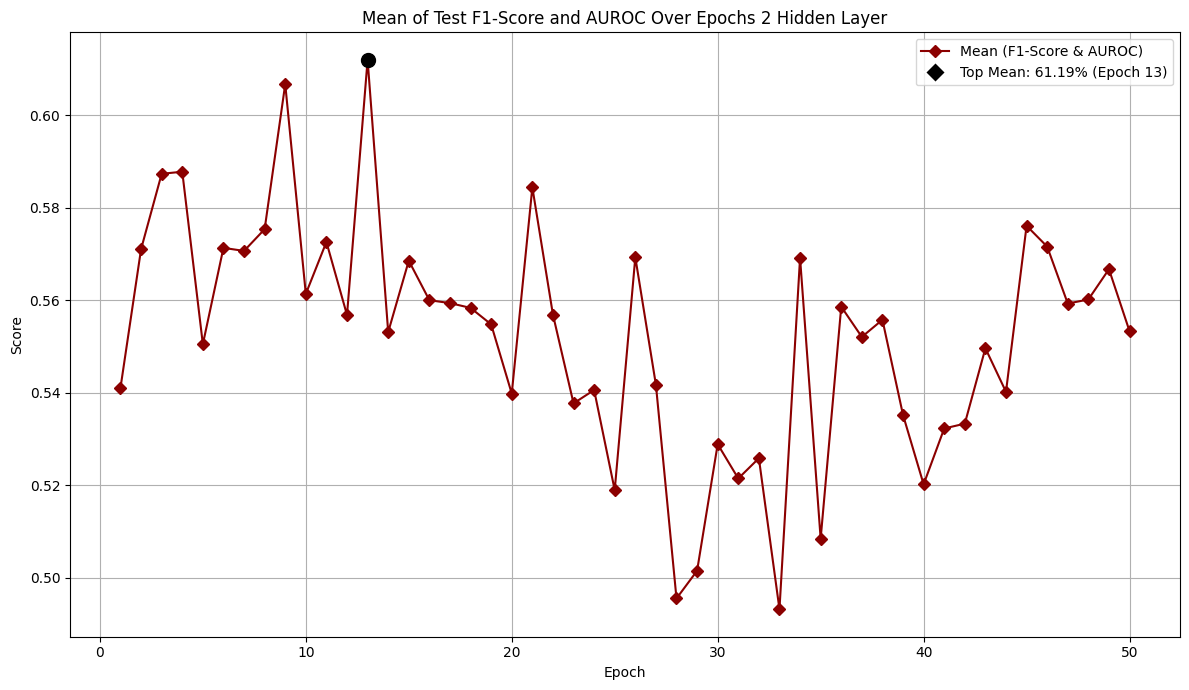

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/small_train_result_512_512_neuron.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot hanya 1 garis: mean dari F1 dan AUROC
    mean_line, = plt.plot(
        df_results['Epoch'],
        df_results['Mean F1-AUROC'],
        marker='D',
        label='Mean (F1-Score & AUROC)',
        color='darkred',
        linestyle='-'
    )

    # Titik tertinggi dari mean
    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='D', color='w',
               label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Mean of Test F1-Score and AUROC Over Epochs 2 Hidden Layer')
    plt.grid(True)
    plt.legend(handles=[mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


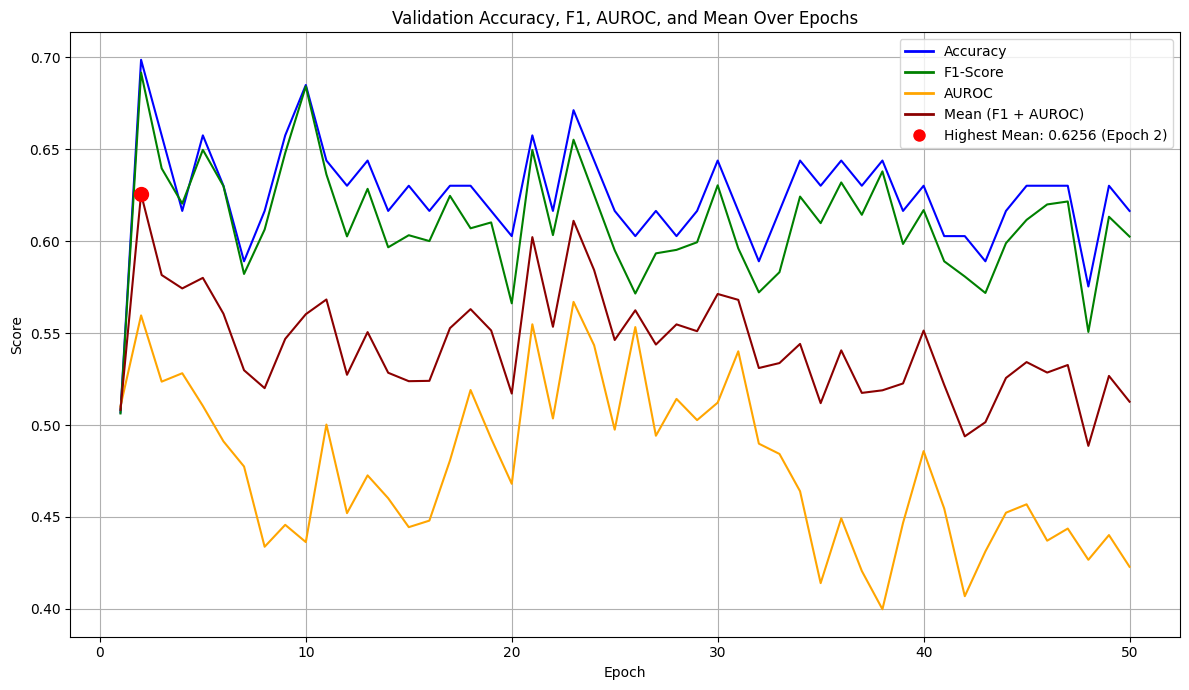

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_epsilon100.csv')

    # Hitung Mean F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot semua metrik
    acc_line, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'], label='Accuracy', color='blue')
    f1_line, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'], label='F1-Score', color='green')
    auroc_line, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'], label='AUROC', color='orange')
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'], label='Mean (F1 + AUROC)', color='darkred', linestyle='-')

    # Titik tertinggi dari Mean
    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='red', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], color='blue', lw=2, label='Accuracy'),
        Line2D([0], [0], color='green', lw=2, label='F1-Score'),
        Line2D([0], [0], color='orange', lw=2, label='AUROC'),
        Line2D([0], [0], color='darkred', lw=2, label='Mean (F1 + AUROC)'),
        Line2D([0], [0], marker='o', color='w',
               label=f'Highest Mean: {mean_val:.4f} (Epoch {mean_epoch})',
               markerfacecolor='red', markersize=10)
    ]

    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1, AUROC, and Mean Over Epochs')
    plt.grid(True)
    plt.legend(handles=custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


# LARGE CHART 512 NEURON

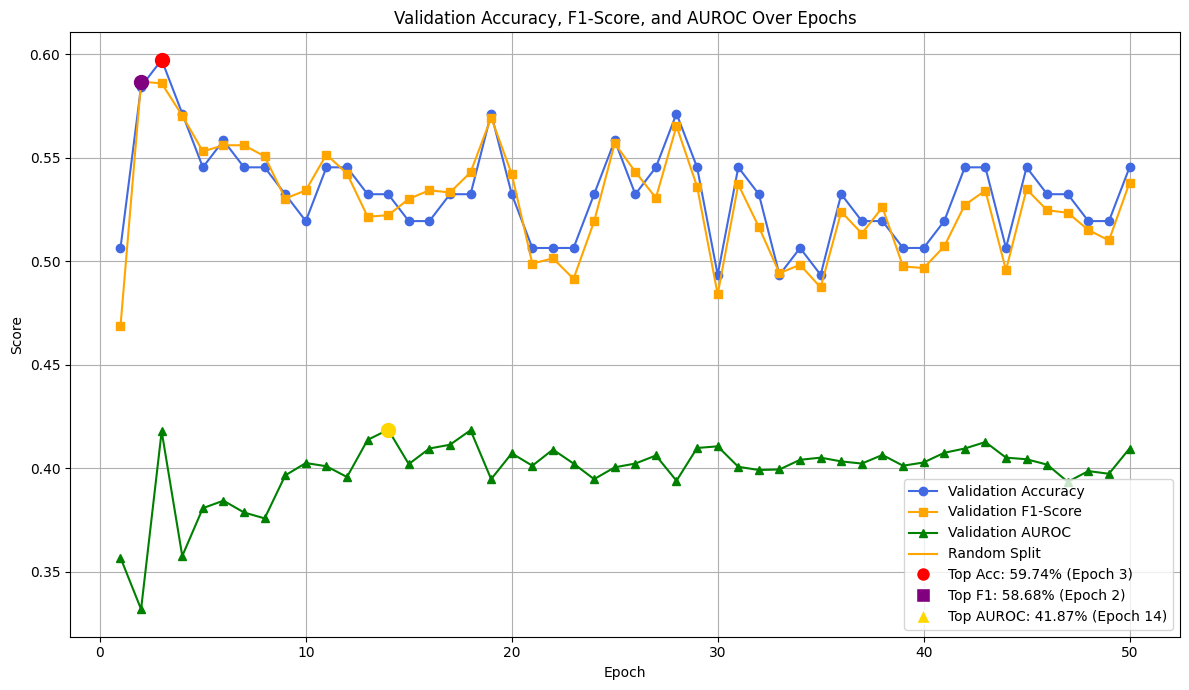

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/large_eps50_train_result_512_neuron.csv')

    plt.figure(figsize=(12, 7))

    # Plot masing-masing metrik dengan warna dan marker berbeda
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'], marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'], marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'], marker='^', label='Validation AUROC', color='green')

    # Top Accuracy
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    # Top F1-Score
    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    # Top AUROC
    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    # Keterangan tambahan (custom legend entries)
    custom_legend = [
        Line2D([0], [0], color='orange', label='Random Split'),
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10)
    ]

    # Tampilan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, and AUROC Over Epochs')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: training_results.csv not found. Please ensure the training process completed successfully.")
except Exception as e:
    print(f"An error occurred: {e}")


# LARGE CHART 512 512 NEURON

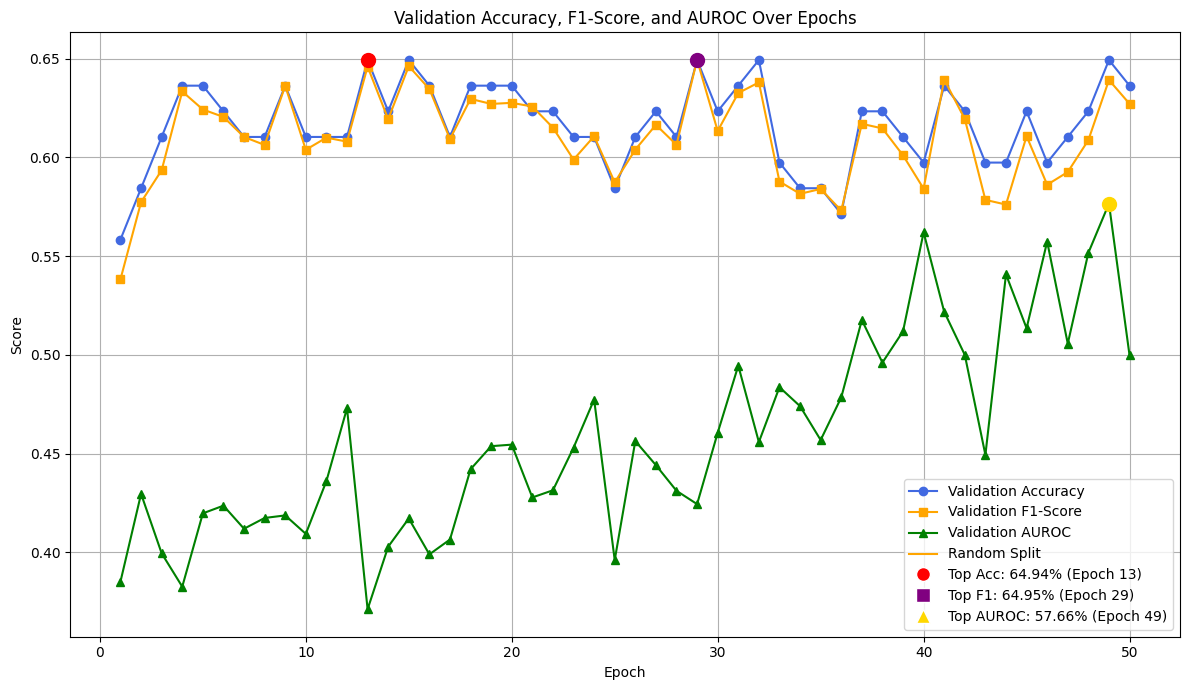

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/large_lr5e_train_result_512_512_neuron.csv')

    plt.figure(figsize=(12, 7))

    # Plot masing-masing metrik dengan warna dan marker berbeda
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'], marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'], marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'], marker='^', label='Validation AUROC', color='green')

    # Top Accuracy
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    # Top F1-Score
    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    # Top AUROC
    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    # Keterangan tambahan (custom legend entries)
    custom_legend = [
        Line2D([0], [0], color='orange', label='Random Split'),
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10)
    ]

    # Tampilan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, and AUROC Over Epochs')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: training_results.csv not found. Please ensure the training process completed successfully.")
except Exception as e:
    print(f"An error occurred: {e}")


# Rumusan Masalah 2: Konfigurasi Gamma dan Epsilon

## Gamma = 0.1 dan Epsilon = 50

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.1
QC_CPN_EPSILON = 50

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_gamma0.1.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1638, Max: 0.4360, Mean: 0.2781, Std: 0.0609
Confidence scores (Unknown) - Min: 0.1520, Max: 0.4173, Mean: 0.2638, Std: 0.0733
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=988.1901, Train Acc (Known)=0.4994, Train F1 (Known)=0.5092, Val Loss (Known)=952.4654, Val Acc (Known)=0.5753, Val F1 (Known)=0.5519, Val AUROC (Known vs Unknown)=0.5827, Time=0.44s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1637, Max: 0.4220, Mean

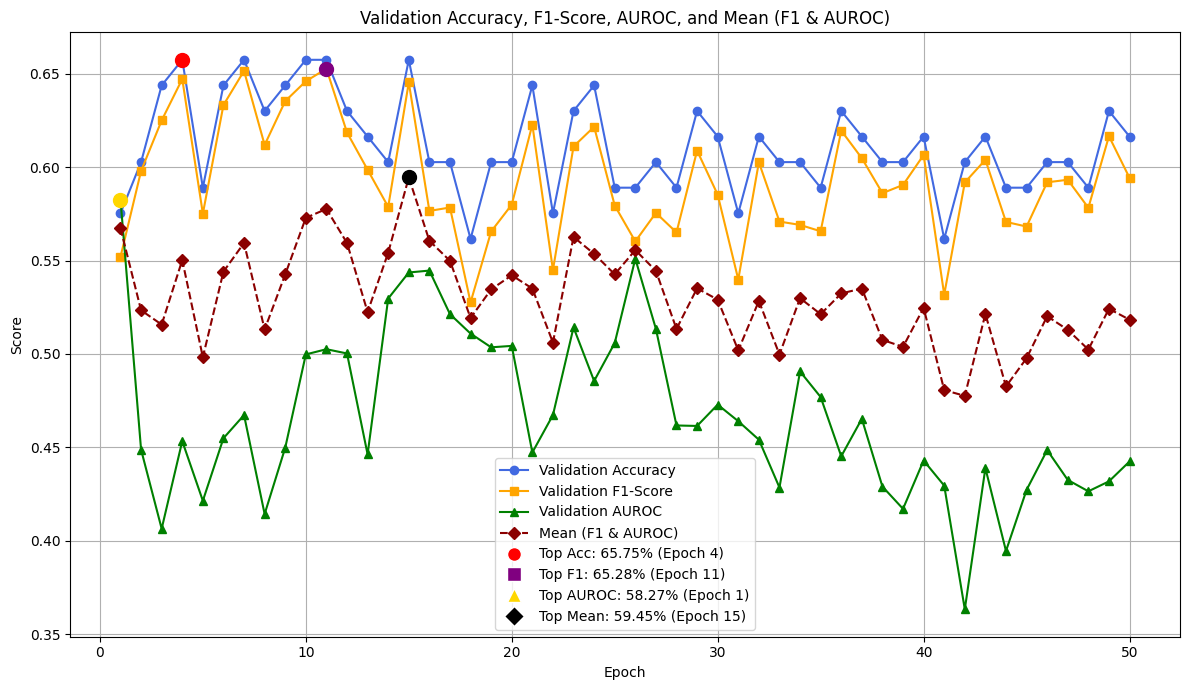

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_gamma0.1.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## Gamma = 0.2 dan Epsilon = 50

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.2
QC_CPN_EPSILON = 50

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_gamma0.2.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1801, Max: 0.5620, Mean: 0.3595, Std: 0.0809
Confidence scores (Unknown) - Min: 0.1624, Max: 0.5442, Mean: 0.3124, Std: 0.0950
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=994.4155, Train Acc (Known)=0.5211, Train F1 (Known)=0.5355, Val Loss (Known)=957.4048, Val Acc (Known)=0.5479, Val F1 (Known)=0.5341, Val AUROC (Known vs Unknown)=0.6585, Time=0.45s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1344, Max: 0.3806, Mean

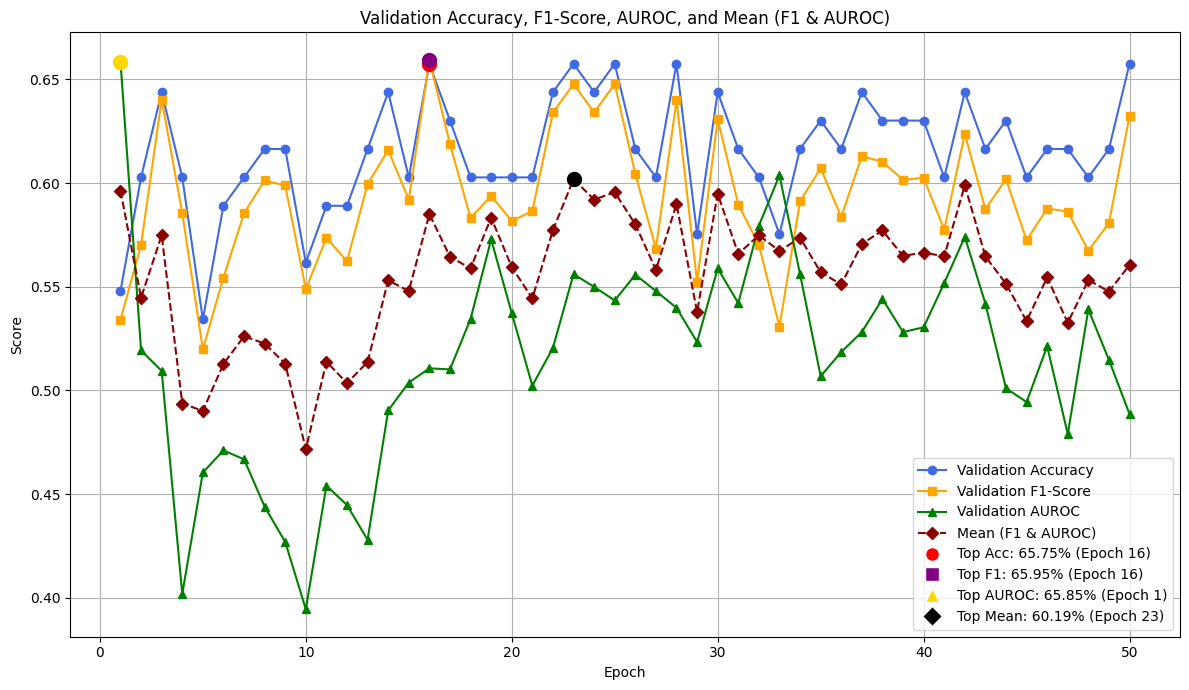

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_gamma0.2.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## Gamma = 0.3 dan Epsilon = 50

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.3
QC_CPN_EPSILON = 50

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_gamma0.3.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1221, Max: 0.3475, Mean: 0.2179, Std: 0.0440
Confidence scores (Unknown) - Min: 0.1385, Max: 0.3058, Mean: 0.2037, Std: 0.0364
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=1003.1876, Train Acc (Known)=0.5344, Train F1 (Known)=0.5127, Val Loss (Known)=959.4000, Val Acc (Known)=0.6027, Val F1 (Known)=0.5488, Val AUROC (Known vs Unknown)=0.5964, Time=0.42s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1271, Max: 0.3241, Mea

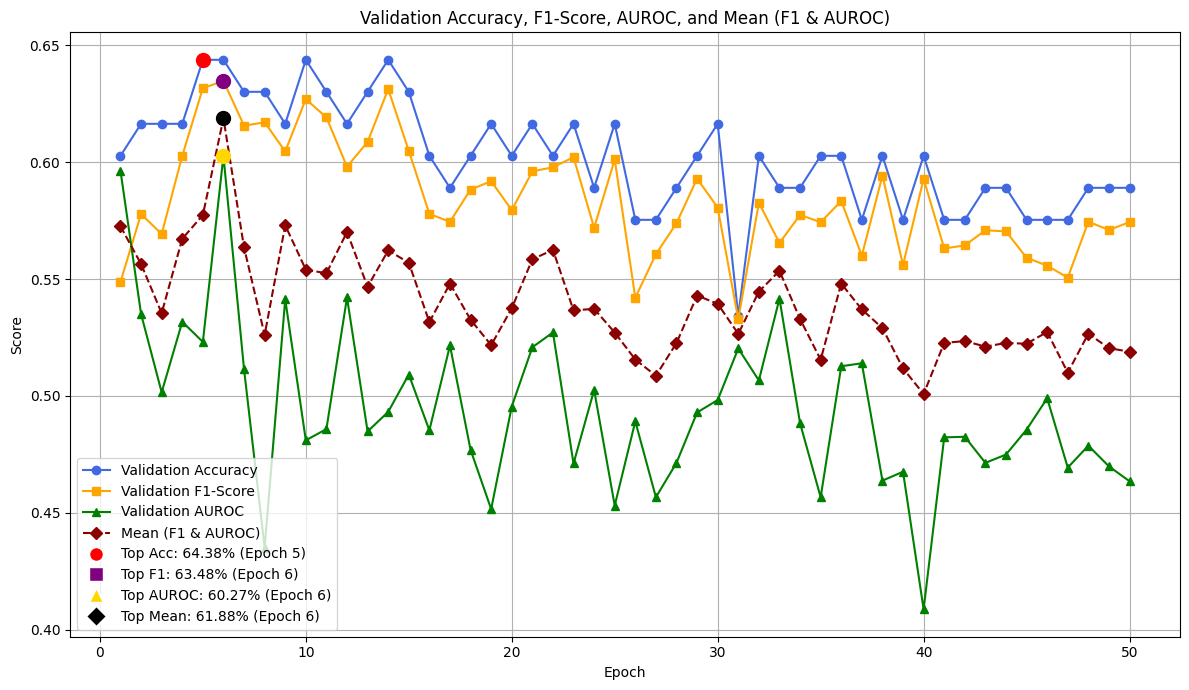

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_gamma0.3.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## Gamma = 0.4 dan Epsilon = 50

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.4
QC_CPN_EPSILON = 50

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_gamma0.4.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1549, Max: 0.3538, Mean: 0.2219, Std: 0.0381
Confidence scores (Unknown) - Min: 0.1483, Max: 0.4656, Mean: 0.2251, Std: 0.0490
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=998.1731, Train Acc (Known)=0.5417, Train F1 (Known)=0.5268, Val Loss (Known)=956.7575, Val Acc (Known)=0.5890, Val F1 (Known)=0.5203, Val AUROC (Known vs Unknown)=0.4939, Time=0.43s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1612, Max: 0.4479, Mean

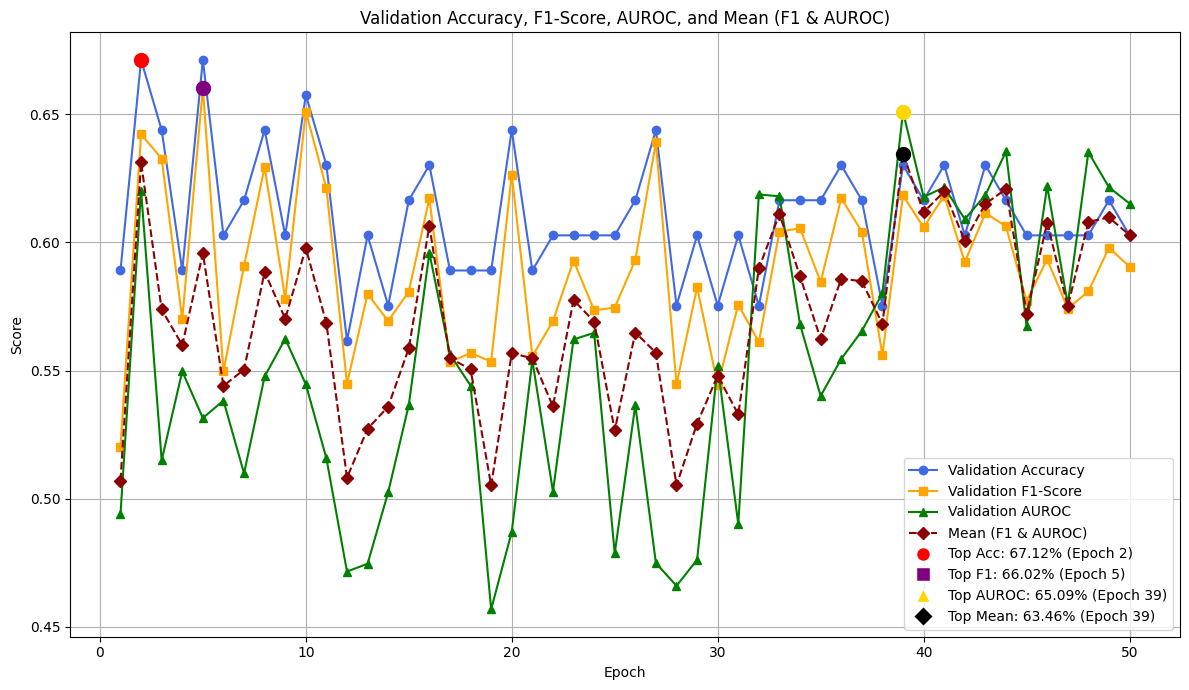

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_gamma0.4.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## Gamma = 0.6 dan Epsilon = 50

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.6
QC_CPN_EPSILON = 50

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_gamma0.6.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1599, Max: 0.5676, Mean: 0.2789, Std: 0.0989
Confidence scores (Unknown) - Min: 0.1603, Max: 0.5701, Mean: 0.2969, Std: 0.0993
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=992.1930, Train Acc (Known)=0.5539, Train F1 (Known)=0.5395, Val Loss (Known)=958.6690, Val Acc (Known)=0.6027, Val F1 (Known)=0.5723, Val AUROC (Known vs Unknown)=0.4305, Time=0.43s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1313, Max: 0.3426, Mean

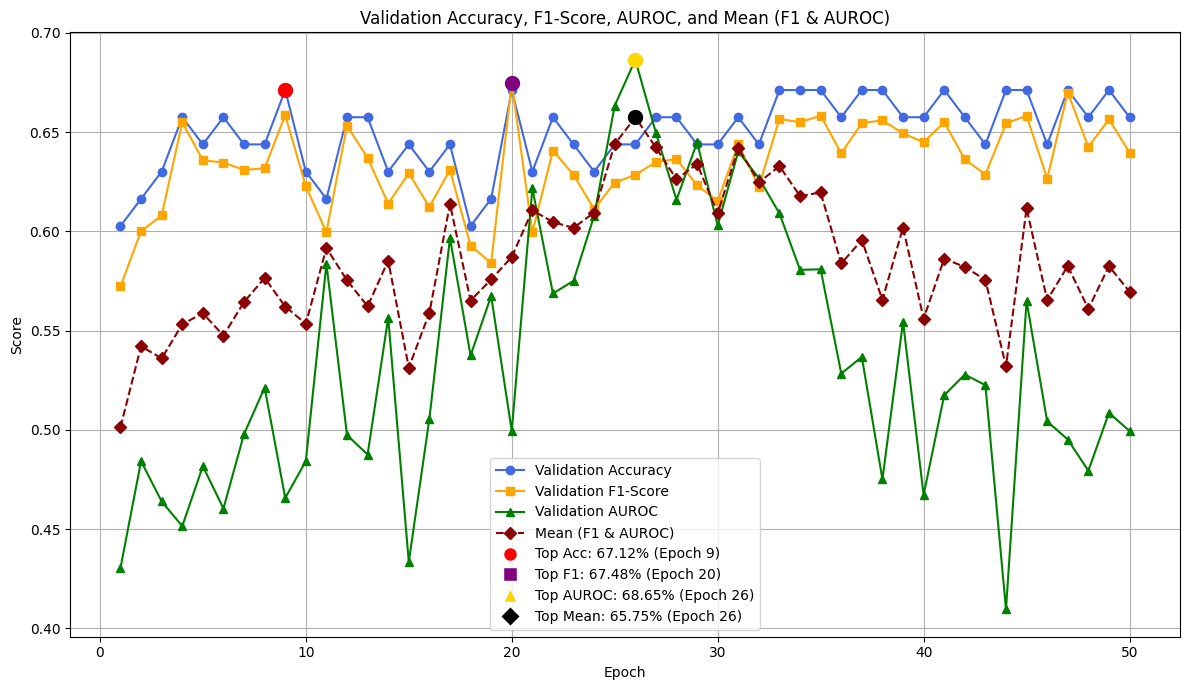

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_gamma0.6.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## Gamma = 0.7 dan Epsilon = 50

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.7
QC_CPN_EPSILON = 50

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_gamma0.7.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1548, Max: 0.4718, Mean: 0.2681, Std: 0.0729
Confidence scores (Unknown) - Min: 0.1664, Max: 0.4579, Mean: 0.2763, Std: 0.0681
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=1003.9156, Train Acc (Known)=0.5489, Train F1 (Known)=0.5593, Val Loss (Known)=965.9627, Val Acc (Known)=0.6575, Val F1 (Known)=0.6337, Val AUROC (Known vs Unknown)=0.4513, Time=0.43s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1299, Max: 0.5383, Mea

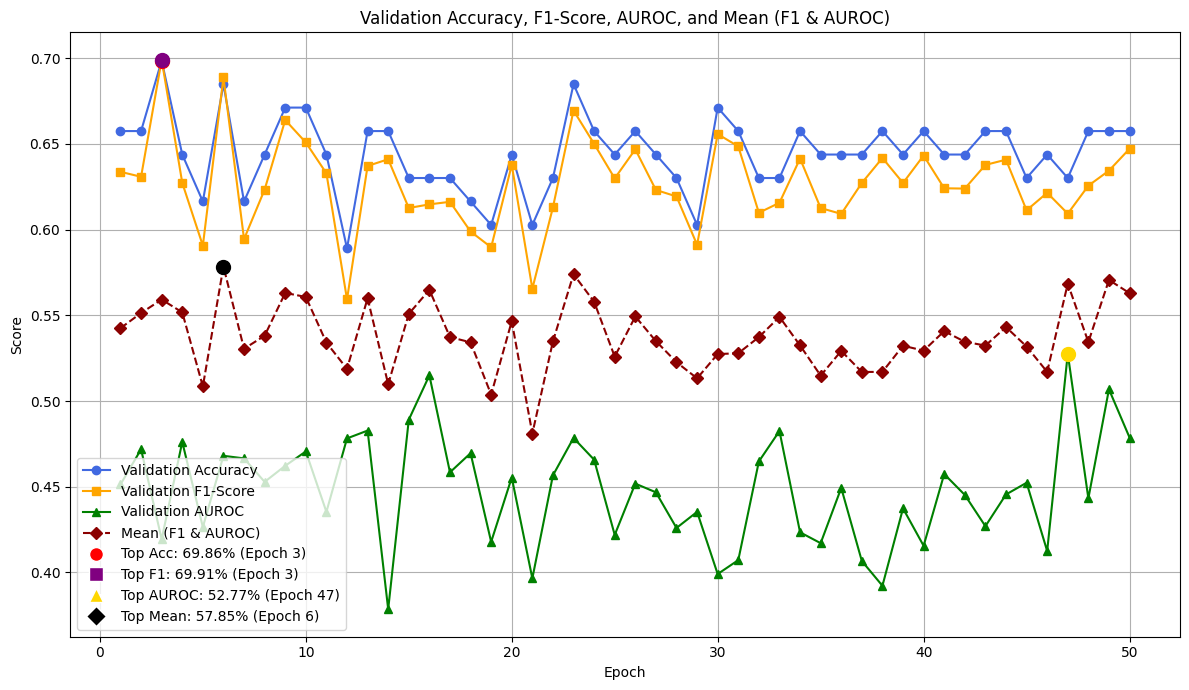

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_gamma0.7.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## Gamma = 0.8 dan Epsilon = 50

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.8
QC_CPN_EPSILON = 50

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_gamma0.8.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1915, Max: 0.5665, Mean: 0.3615, Std: 0.1003
Confidence scores (Unknown) - Min: 0.1988, Max: 0.6267, Mean: 0.3265, Std: 0.0970
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=996.4728, Train Acc (Known)=0.5189, Train F1 (Known)=0.5192, Val Loss (Known)=961.3576, Val Acc (Known)=0.4795, Val F1 (Known)=0.4590, Val AUROC (Known vs Unknown)=0.6060, Time=0.52s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1766, Max: 0.5652, Mean

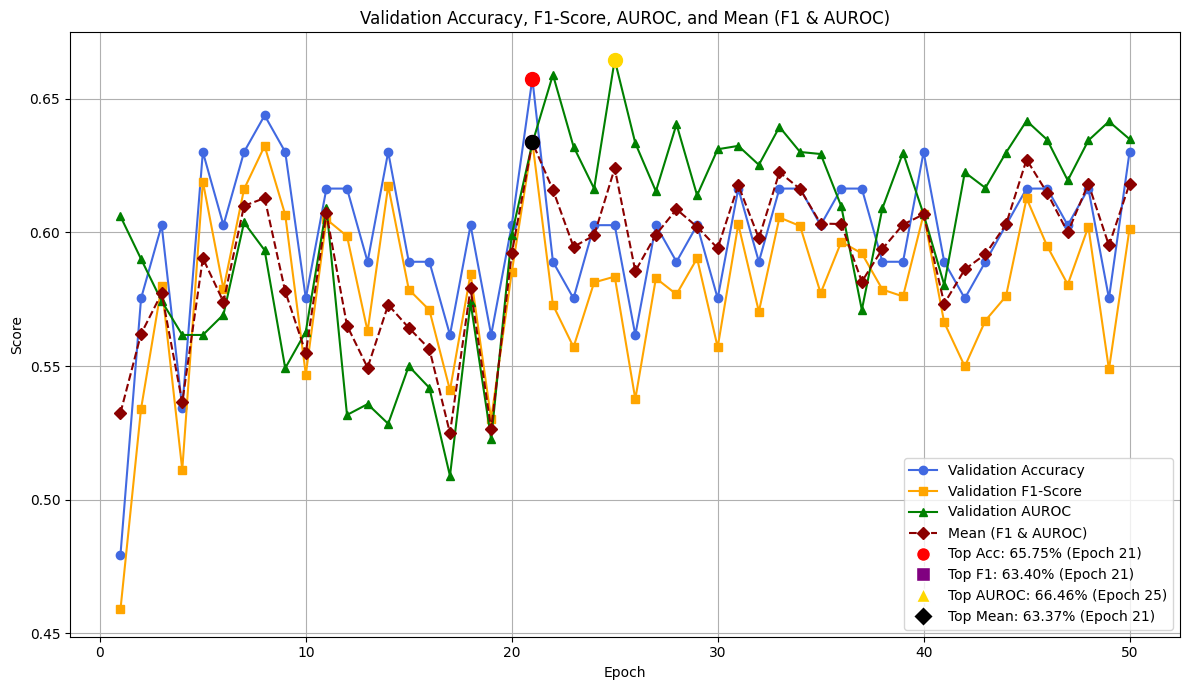

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_gamma0.8.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## Gamma = 0.9 dan Epsilon = 50

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.9
QC_CPN_EPSILON = 50

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_gamma0.9.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1392, Max: 0.4135, Mean: 0.2493, Std: 0.0513
Confidence scores (Unknown) - Min: 0.1589, Max: 0.5186, Mean: 0.2311, Std: 0.0590
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=989.9368, Train Acc (Known)=0.4883, Train F1 (Known)=0.4809, Val Loss (Known)=947.4987, Val Acc (Known)=0.6164, Val F1 (Known)=0.5816, Val AUROC (Known vs Unknown)=0.6385, Time=0.43s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1504, Max: 0.3889, Mean

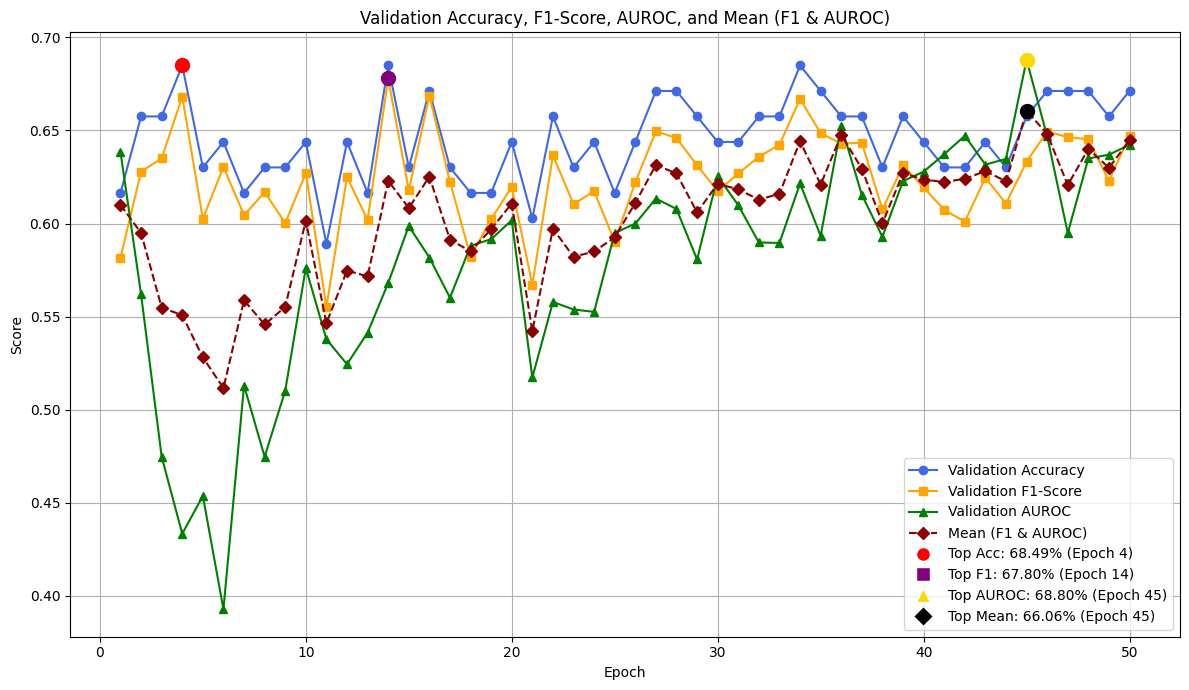

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_gamma0.9.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


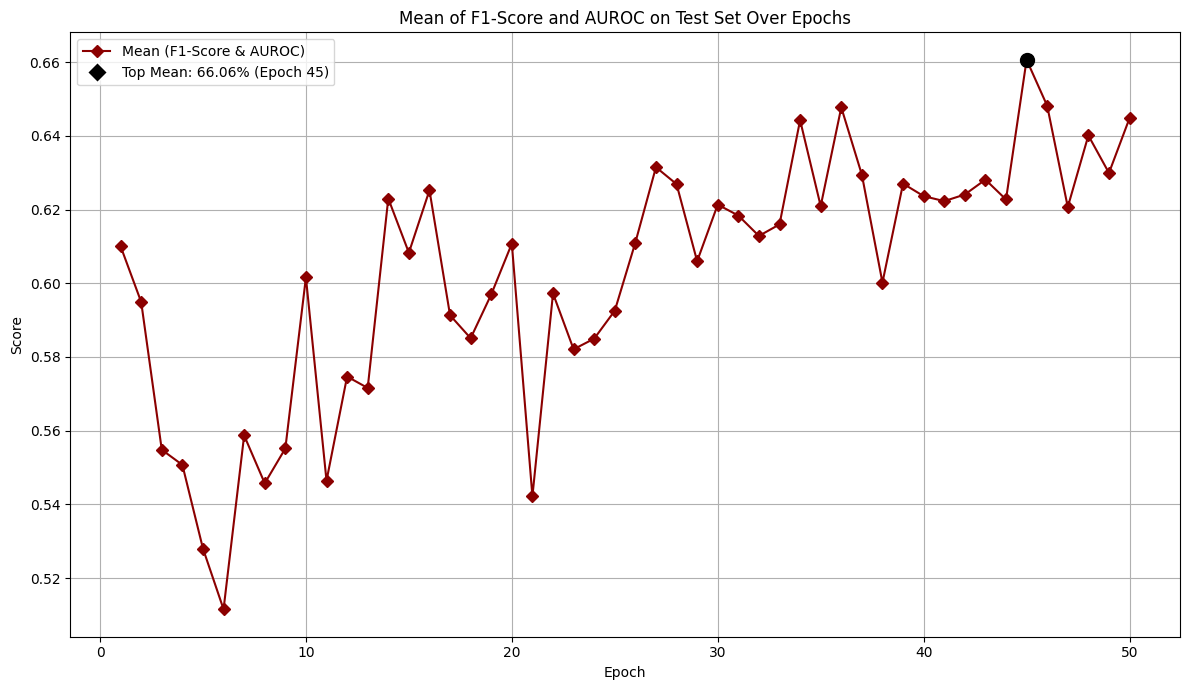

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_gamma0.9.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot hanya 1 garis: mean dari F1 dan AUROC
    mean_line, = plt.plot(
        df_results['Epoch'],
        df_results['Mean F1-AUROC'],
        marker='D',
        label='Mean (F1-Score & AUROC)',
        color='darkred',
        linestyle='-'
    )

    # Titik tertinggi dari mean
    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='D', color='w',
               label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Mean of F1-Score and AUROC on Test Set Over Epochs')
    plt.grid(True)
    plt.legend(handles=[mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## Gamma = 1.0 dan Epsilon = 50

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 1.0
QC_CPN_EPSILON = 50

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_gamma1.0.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1500, Max: 0.5841, Mean: 0.3205, Std: 0.0944
Confidence scores (Unknown) - Min: 0.1624, Max: 0.5212, Mean: 0.2934, Std: 0.0857
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=981.8381, Train Acc (Known)=0.5444, Train F1 (Known)=0.5294, Val Loss (Known)=935.1649, Val Acc (Known)=0.5068, Val F1 (Known)=0.4309, Val AUROC (Known vs Unknown)=0.5804, Time=0.42s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1580, Max: 0.4308, Mean

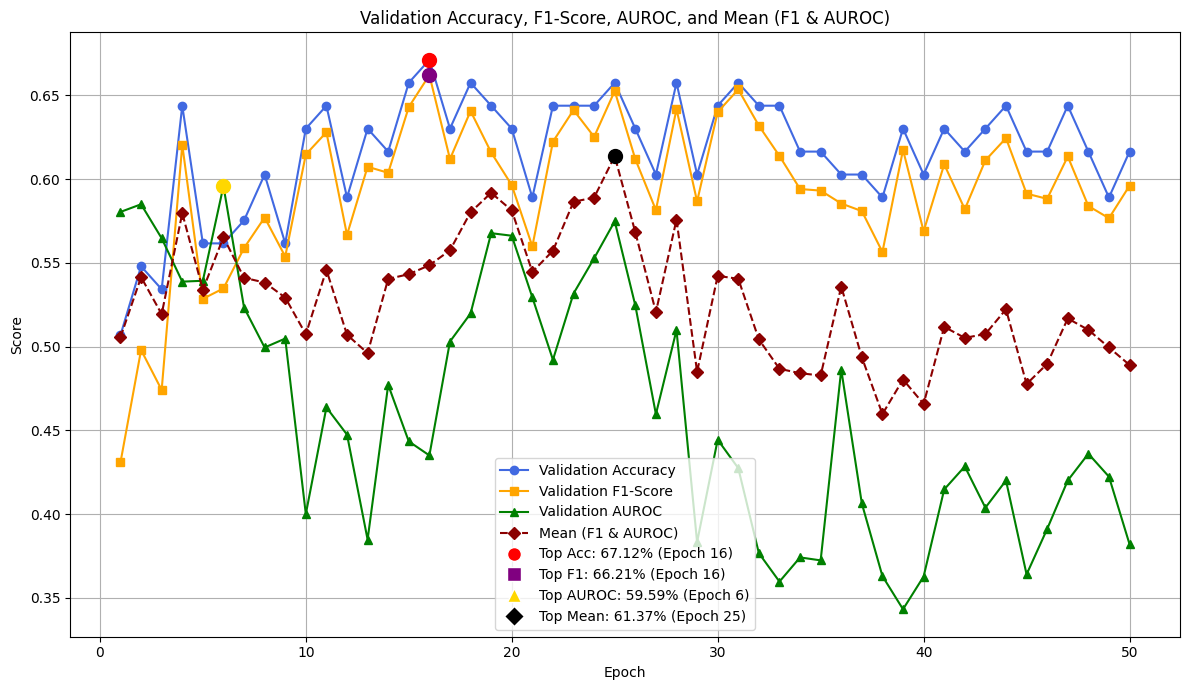

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_gamma1.0.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## UJI EPSILON

## Epsilon 10

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.9
QC_CPN_EPSILON = 10

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_epsilon10.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1314, Max: 0.3297, Mean: 0.2072, Std: 0.0384
Confidence scores (Unknown) - Min: 0.1491, Max: 0.4326, Mean: 0.2123, Std: 0.0465
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=182.8687, Train Acc (Known)=0.5811, Train F1 (Known)=0.5633, Val Loss (Known)=177.6867, Val Acc (Known)=0.5890, Val F1 (Known)=0.5644, Val AUROC (Known vs Unknown)=0.5023, Time=0.76s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1434, Max: 0.4106, Mean

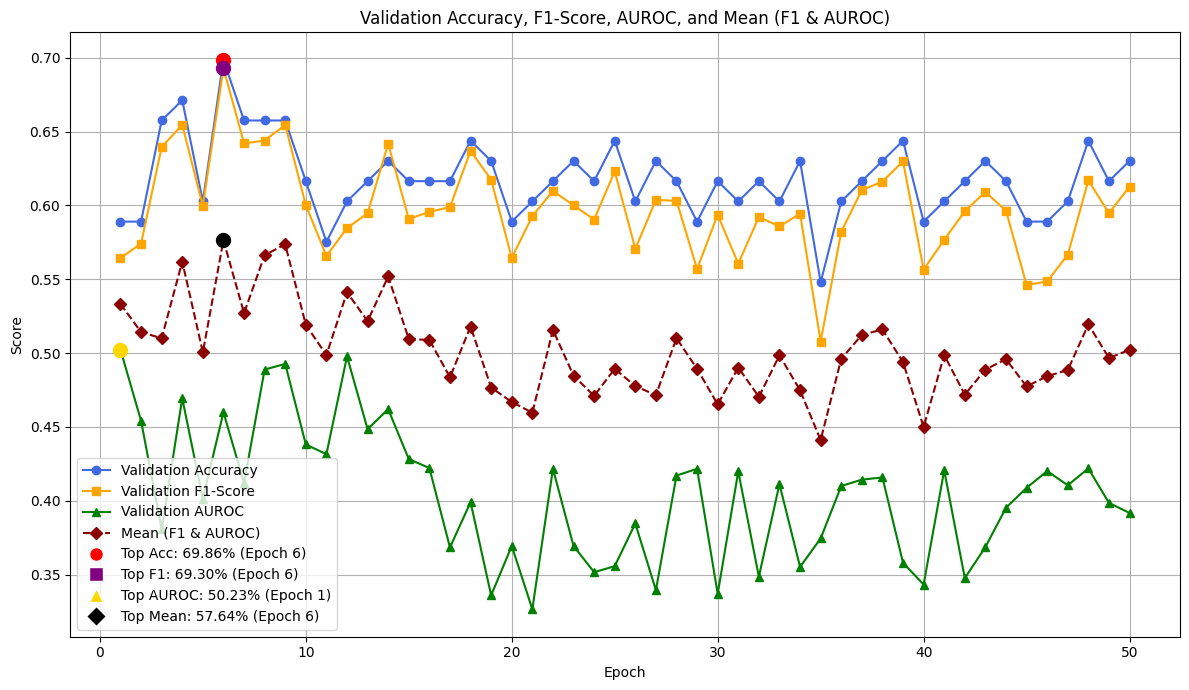

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_epsilon10.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## Epsilon 20

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.9
QC_CPN_EPSILON = 20

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_epsilon20.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.2315, Max: 0.4827, Mean: 0.3377, Std: 0.0577
Confidence scores (Unknown) - Min: 0.2187, Max: 0.5187, Mean: 0.3527, Std: 0.0738
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=391.5567, Train Acc (Known)=0.5178, Train F1 (Known)=0.5159, Val Loss (Known)=378.6364, Val Acc (Known)=0.5890, Val F1 (Known)=0.5639, Val AUROC (Known vs Unknown)=0.4371, Time=0.60s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.2100, Max: 0.5327, Mean

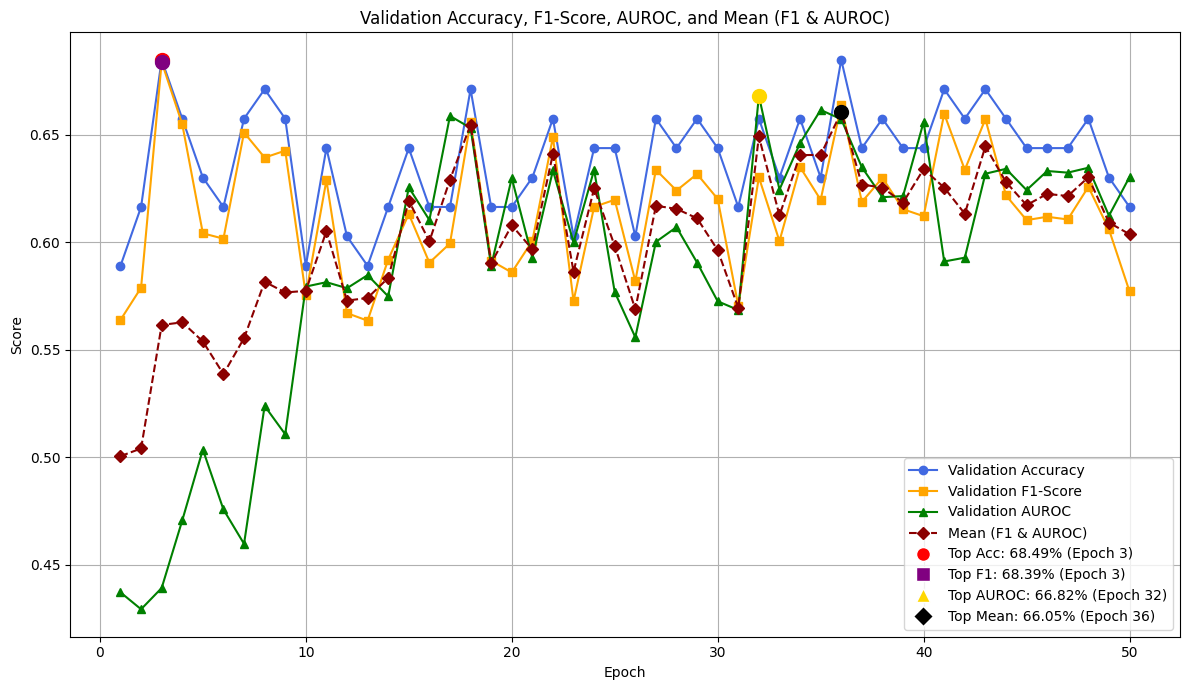

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_epsilon20.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## Epsilon 30

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.9
QC_CPN_EPSILON = 30

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_epsilon30.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1514, Max: 0.5158, Mean: 0.2738, Std: 0.0727
Confidence scores (Unknown) - Min: 0.1597, Max: 0.4864, Mean: 0.2613, Std: 0.0594
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=598.1262, Train Acc (Known)=0.5583, Train F1 (Known)=0.5498, Val Loss (Known)=574.1317, Val Acc (Known)=0.6301, Val F1 (Known)=0.6144, Val AUROC (Known vs Unknown)=0.5327, Time=0.44s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1500, Max: 0.3956, Mean

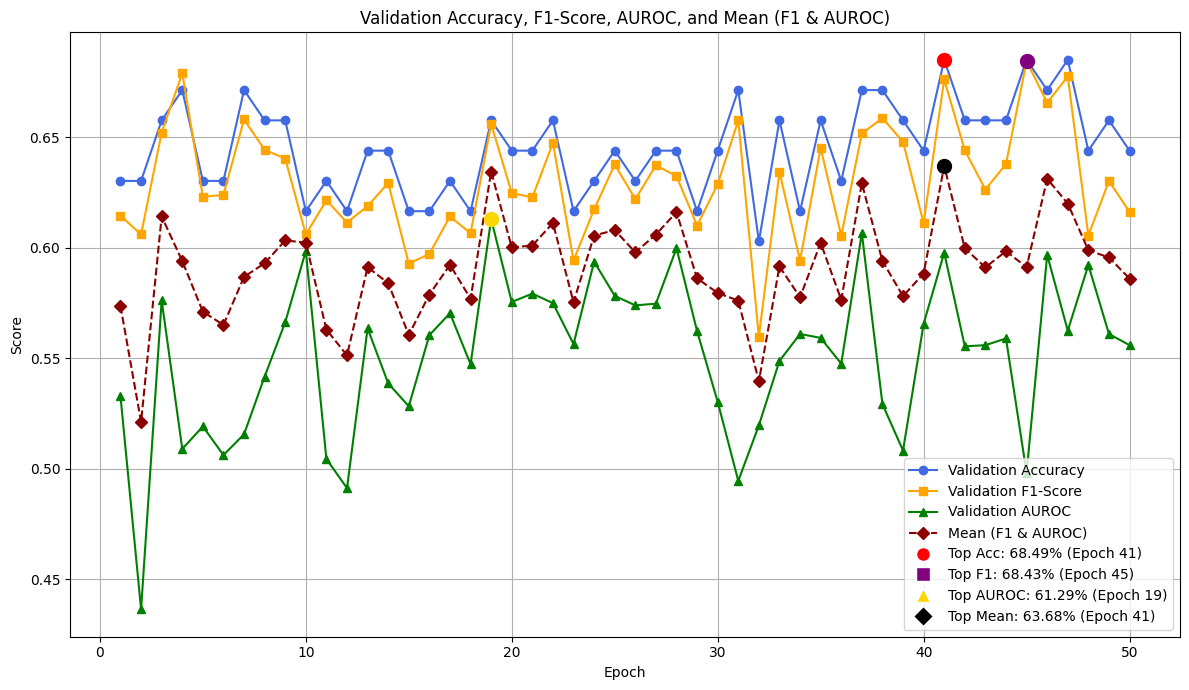

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_epsilon30.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## Epsilon 40

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.9
QC_CPN_EPSILON = 40

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_epsilon40.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1973, Max: 0.8070, Mean: 0.4312, Std: 0.1225
Confidence scores (Unknown) - Min: 0.1639, Max: 0.7904, Mean: 0.4996, Std: 0.1627
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=801.5701, Train Acc (Known)=0.5211, Train F1 (Known)=0.4992, Val Loss (Known)=779.0816, Val Acc (Known)=0.5342, Val F1 (Known)=0.5024, Val AUROC (Known vs Unknown)=0.3782, Time=0.43s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.2002, Max: 0.8478, Mean

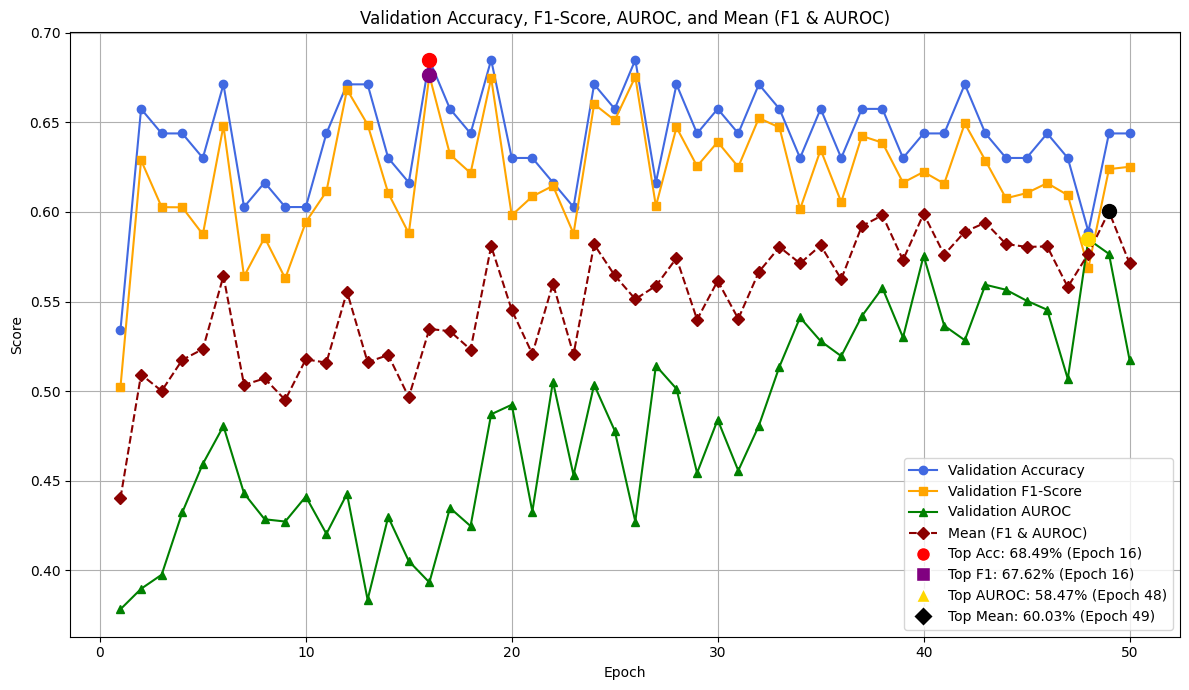

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_epsilon40.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## Epsilon 60

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.9
QC_CPN_EPSILON = 60

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_epsilon60.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1597, Max: 0.4493, Mean: 0.2567, Std: 0.0567
Confidence scores (Unknown) - Min: 0.1663, Max: 0.3645, Mean: 0.2392, Std: 0.0486
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=1201.9006, Train Acc (Known)=0.5144, Train F1 (Known)=0.5023, Val Loss (Known)=1156.1501, Val Acc (Known)=0.4932, Val F1 (Known)=0.4710, Val AUROC (Known vs Unknown)=0.5977, Time=0.44s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1457, Max: 0.4469, Me

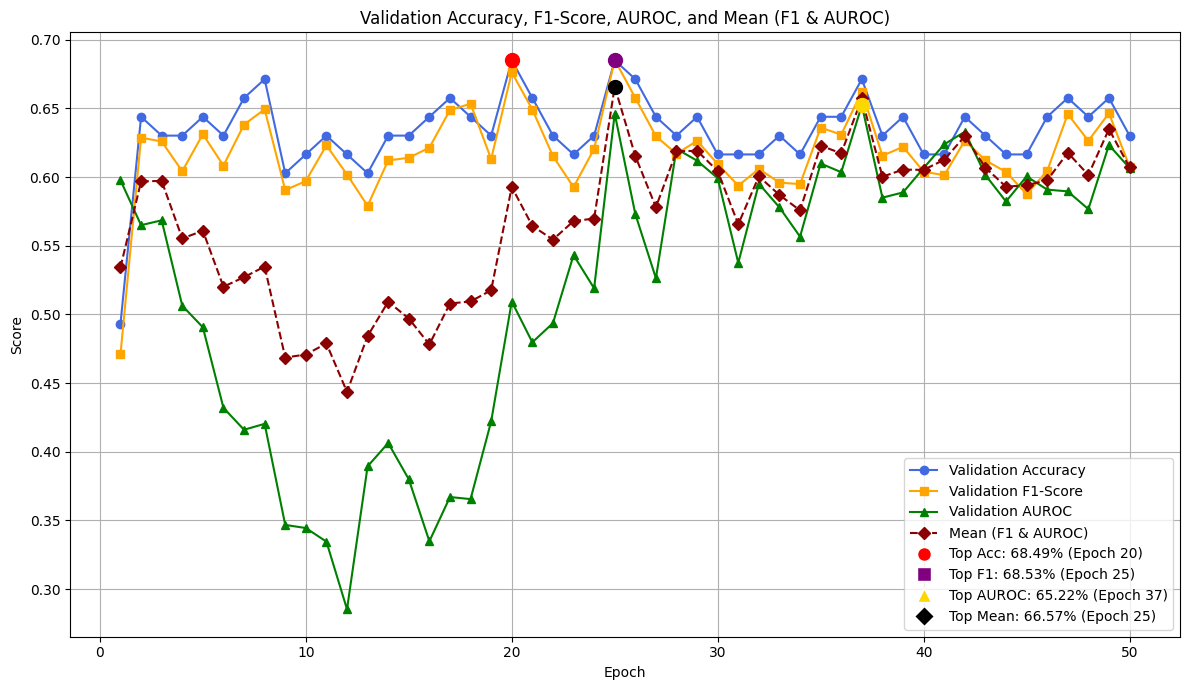

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_epsilon60.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


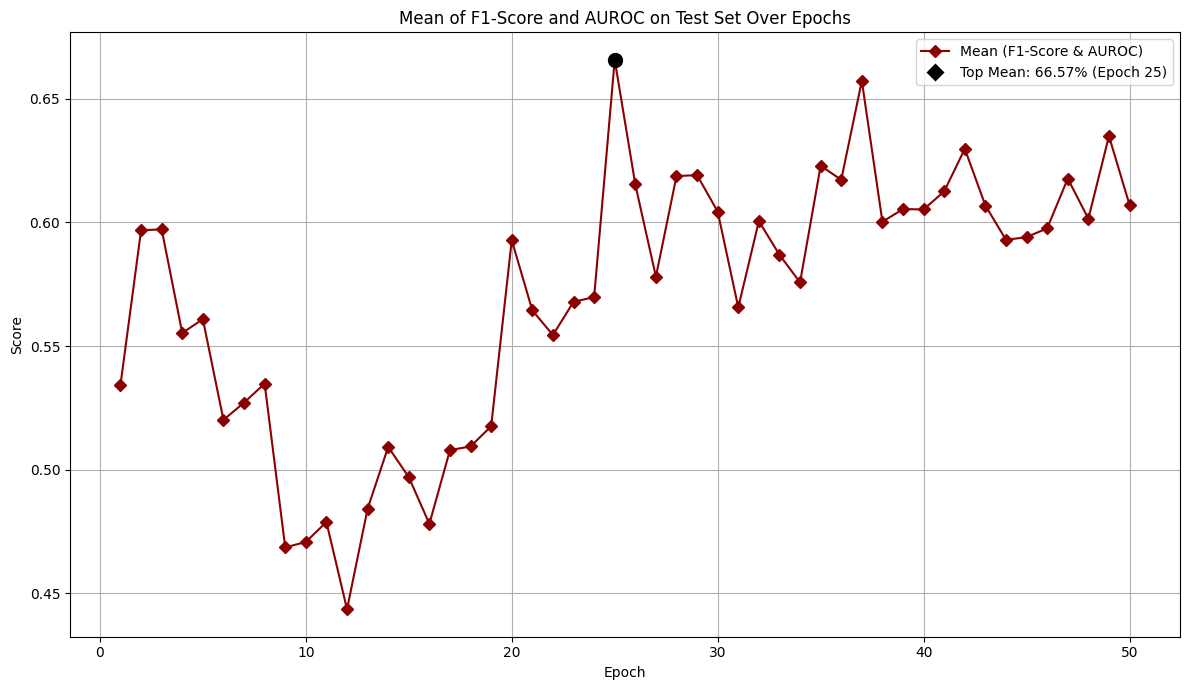

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_epsilon60.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot hanya 1 garis: mean dari F1 dan AUROC
    mean_line, = plt.plot(
        df_results['Epoch'],
        df_results['Mean F1-AUROC'],
        marker='D',
        label='Mean (F1-Score & AUROC)',
        color='darkred',
        linestyle='-'
    )

    # Titik tertinggi dari mean
    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='D', color='w',
               label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Mean of F1-Score and AUROC on Test Set Over Epochs')
    plt.grid(True)
    plt.legend(handles=[mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## Epsilon 70

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.9
QC_CPN_EPSILON = 70

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_epsilon70.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1648, Max: 0.6563, Mean: 0.3507, Std: 0.1275
Confidence scores (Unknown) - Min: 0.1459, Max: 0.6599, Mean: 0.3366, Std: 0.1265
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=1406.4597, Train Acc (Known)=0.5717, Train F1 (Known)=0.5620, Val Loss (Known)=1361.7867, Val Acc (Known)=0.5479, Val F1 (Known)=0.4848, Val AUROC (Known vs Unknown)=0.5292, Time=0.42s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1608, Max: 0.7079, Me

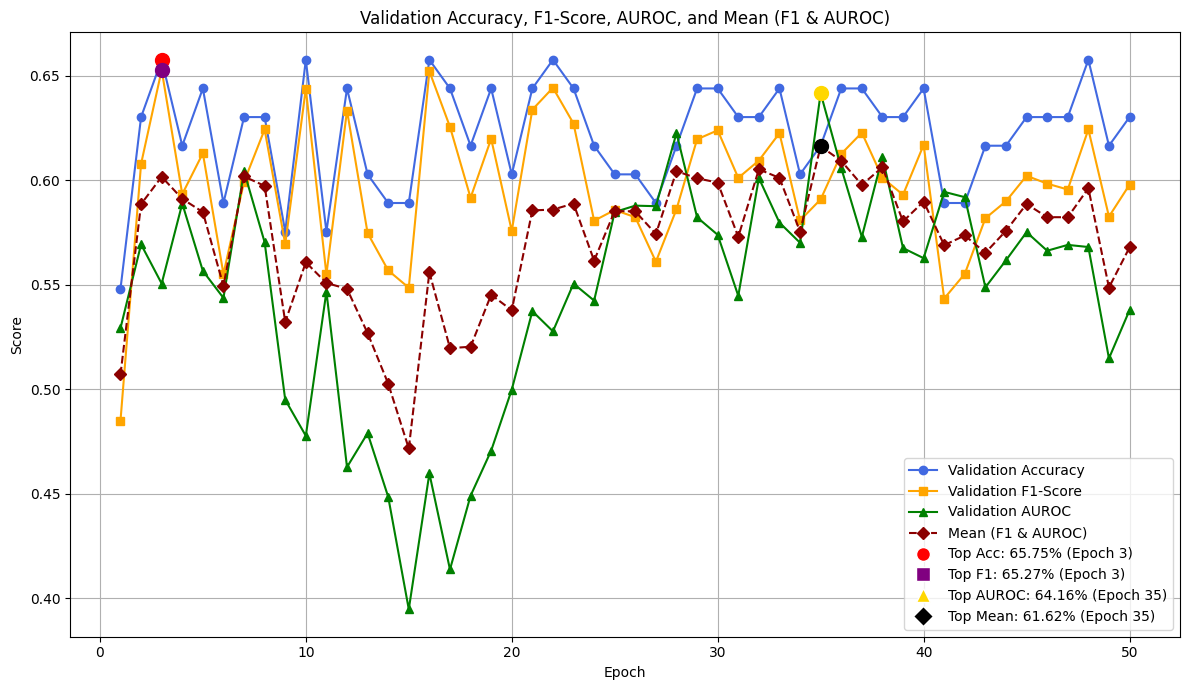

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_epsilon70.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## Epsilon 80

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.9
QC_CPN_EPSILON = 80

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_epsilon80.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1527, Max: 0.5094, Mean: 0.3009, Std: 0.0861
Confidence scores (Unknown) - Min: 0.1408, Max: 0.4813, Mean: 0.2681, Std: 0.0859
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=1626.5673, Train Acc (Known)=0.5111, Train F1 (Known)=0.5090, Val Loss (Known)=1568.0897, Val Acc (Known)=0.6301, Val F1 (Known)=0.5861, Val AUROC (Known vs Unknown)=0.6121, Time=0.44s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1447, Max: 0.5437, Me

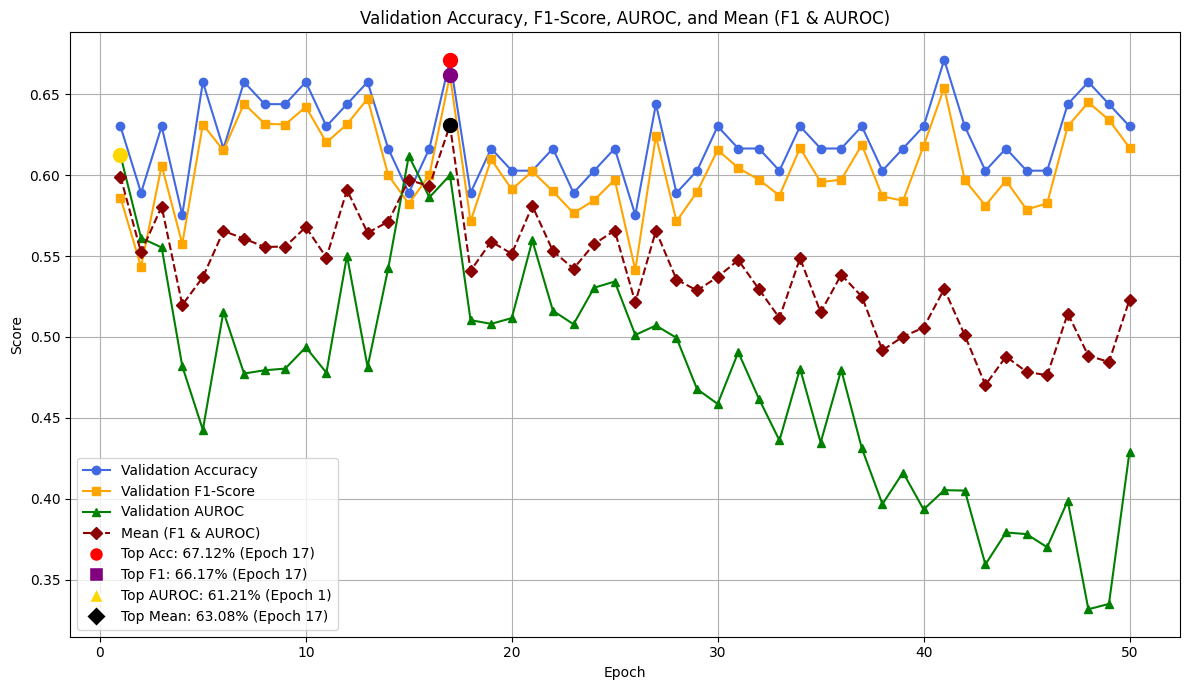

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_epsilon80.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## Epsilon 90

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.9
QC_CPN_EPSILON = 90

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_epsilon90.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1661, Max: 0.5025, Mean: 0.3016, Std: 0.0854
Confidence scores (Unknown) - Min: 0.1394, Max: 0.5809, Mean: 0.2873, Std: 0.0884
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=1815.1881, Train Acc (Known)=0.4717, Train F1 (Known)=0.4480, Val Loss (Known)=1739.2350, Val Acc (Known)=0.6301, Val F1 (Known)=0.5919, Val AUROC (Known vs Unknown)=0.5540, Time=0.43s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1668, Max: 0.4962, Me

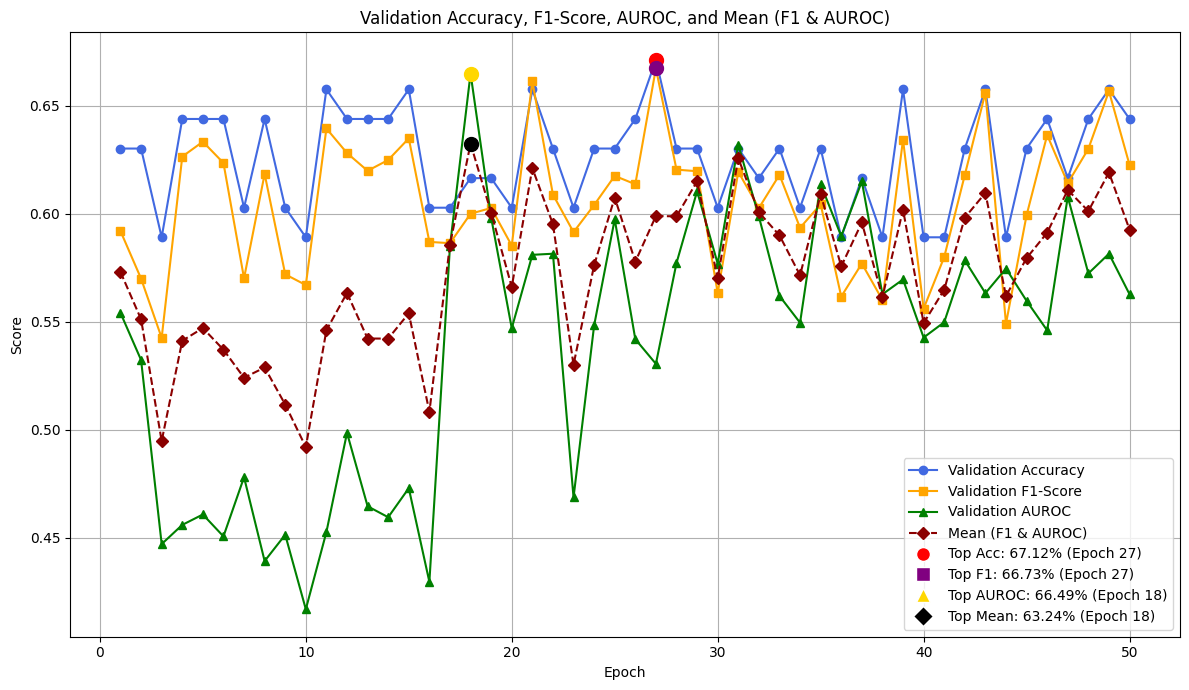

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_epsilon90.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


## Epsilon 100

In [ ]:
# Tentukan ukuran hidden layer yang diinginkan dan fungsi aktivasi
hidden_size1 = 512
hidden_size2 = 512
activation = 'relu' # atau 'sigmoid', 'tanh', dll.

# Determine the feature dimension from the loaded training features
feature_dim = train_features.shape[1]
# Determine the number of classes from the training dataset (or labels)
num_classes = len(train_dataset_images.known_class_to_idx)

QC_CPN_GAMMA = 0.9
QC_CPN_EPSILON = 100

# Inisialisasi QC_CPN dengan hidden layer
qc_cpn = QC_CPN(feature_dim=feature_dim,
                num_classes=num_classes,
                gamma=QC_CPN_GAMMA,
                epsilon=QC_CPN_EPSILON,
                hidden_size1=hidden_size1,
                hidden_size2=hidden_size2, # Masukkan ukuran hidden layer di sini
                activation_function=activation # Masukkan fungsi aktivasi di sini
                ).to(device)

optimizer = torch.optim.Adam(qc_cpn.parameters(), lr=1e-3)

print(f"QC-CPN model initialized with feature_dim={feature_dim}, num_classes={num_classes}")
print(f"Number of training feature samples: {len(train_feature_dataset)}")
print(f"Number of test feature samples (validation): {len(test_feature_dataset)}")


QC-CPN model initialized with feature_dim=2304, num_classes=12
Number of training feature samples: 1800
Number of test feature samples (validation): 127


In [ ]:
print("Starting QC-CPN training...")
# Pass the feature loaders to the train_model function
train_model_OSR(qc_cpn, train_feature_loader, test_feature_loader, optimizer, device, num_epochs=50, output_csv="train_512_512_epsilon100.csv", num_known_classes=num_known_classes)

print("Training finished.")

Starting QC-CPN training...
Epoch 1/50 - Training...
Epoch 1/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1526, Max: 0.4247, Mean: 0.2625, Std: 0.0646
Confidence scores (Unknown) - Min: 0.1362, Max: 0.4390, Mean: 0.2609, Std: 0.0720
--- End AUROC Calculation Debug ---
Epoch 1/50: Train Loss=2061.5589, Train Acc (Known)=0.4850, Train F1 (Known)=0.4830, Val Loss (Known)=1985.5534, Val Acc (Known)=0.5068, Val F1 (Known)=0.5063, Val AUROC (Known vs Unknown)=0.5101, Time=0.50s
Epoch 2/50 - Training...
Epoch 2/50 - Validating (OSR)...
Starting OSR evaluation for 127 samples...
--- AUROC Calculation Debug ---
Number of samples for AUROC: 127
Unique labels for AUROC: [0 1]
Number of Known samples: 73
Number of Unknown samples: 54
Confidence scores (Known) - Min: 0.1569, Max: 0.4094, Me

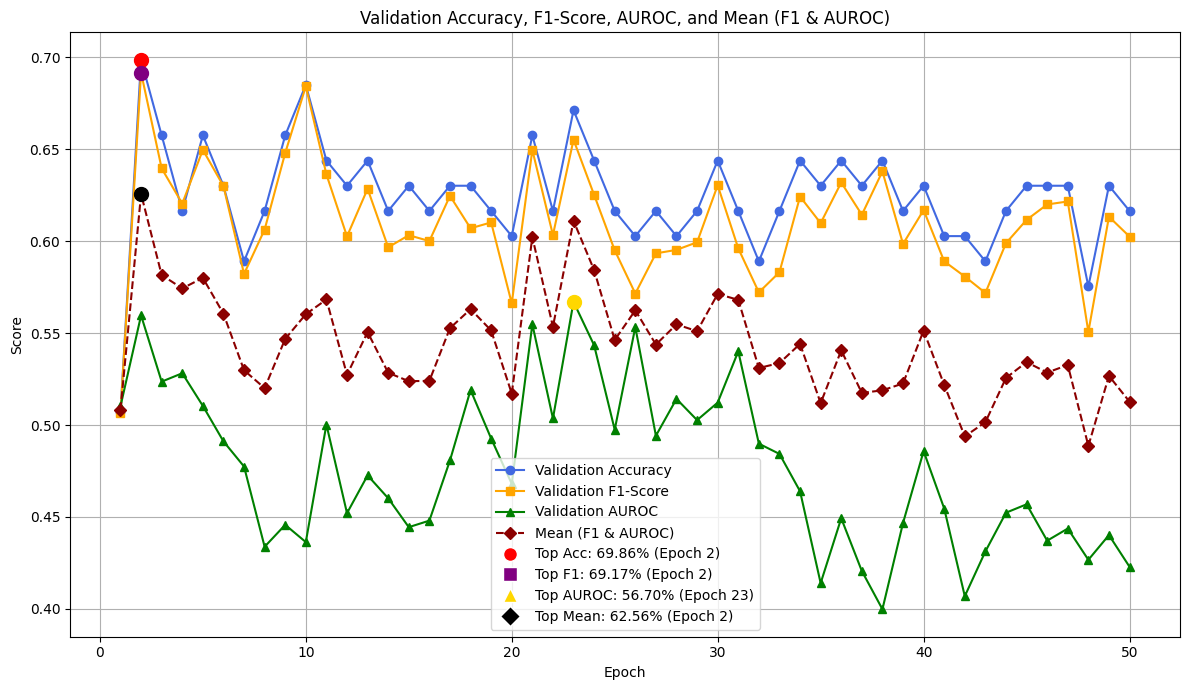

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

try:
    df_results = pd.read_csv('/content/train_512_512_epsilon100.csv')

    # Hitung rata-rata dari F1 dan AUROC
    df_results['Mean F1-AUROC'] = (
        df_results['Val F1-Score (Known)'] + df_results['Val AUROC (Known vs Unknown)']
    ) / 2

    plt.figure(figsize=(12, 7))

    # Plot 3 metrik utama
    line1, = plt.plot(df_results['Epoch'], df_results['Val Accuracy (Known)'],
                      marker='o', label='Validation Accuracy', color='royalblue')
    line2, = plt.plot(df_results['Epoch'], df_results['Val F1-Score (Known)'],
                      marker='s', label='Validation F1-Score', color='orange')
    line3, = plt.plot(df_results['Epoch'], df_results['Val AUROC (Known vs Unknown)'],
                      marker='^', label='Validation AUROC', color='green')

    # Plot rata-rata
    mean_line, = plt.plot(df_results['Epoch'], df_results['Mean F1-AUROC'],
                          marker='D', label='Mean (F1 & AUROC)', color='darkred', linestyle='--')

    # Titik terbaik
    acc_idx = df_results['Val Accuracy (Known)'].idxmax()
    acc_epoch = df_results.loc[acc_idx, 'Epoch']
    acc_val = df_results.loc[acc_idx, 'Val Accuracy (Known)']
    plt.scatter(acc_epoch, acc_val, color='red', s=100, zorder=5)

    f1_idx = df_results['Val F1-Score (Known)'].idxmax()
    f1_epoch = df_results.loc[f1_idx, 'Epoch']
    f1_val = df_results.loc[f1_idx, 'Val F1-Score (Known)']
    plt.scatter(f1_epoch, f1_val, color='purple', s=100, zorder=5)

    auroc_idx = df_results['Val AUROC (Known vs Unknown)'].idxmax()
    auroc_epoch = df_results.loc[auroc_idx, 'Epoch']
    auroc_val = df_results.loc[auroc_idx, 'Val AUROC (Known vs Unknown)']
    plt.scatter(auroc_epoch, auroc_val, color='gold', s=100, zorder=5)

    mean_idx = df_results['Mean F1-AUROC'].idxmax()
    mean_epoch = df_results.loc[mean_idx, 'Epoch']
    mean_val = df_results.loc[mean_idx, 'Mean F1-AUROC']
    plt.scatter(mean_epoch, mean_val, color='black', s=100, zorder=5)

    # Legend khusus
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label=f'Top Acc: {acc_val*100:.2f}% (Epoch {acc_epoch})',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='s', color='w', label=f'Top F1: {f1_val*100:.2f}% (Epoch {f1_epoch})',
               markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='^', color='w', label=f'Top AUROC: {auroc_val*100:.2f}% (Epoch {auroc_epoch})',
               markerfacecolor='gold', markersize=10),
        Line2D([0], [0], marker='D', color='w', label=f'Top Mean: {mean_val*100:.2f}% (Epoch {mean_epoch})',
               markerfacecolor='black', markersize=10)
    ]

    # Tampilkan grafik
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy, F1-Score, AUROC, and Mean (F1 & AUROC)')
    plt.grid(True)
    plt.legend(handles=[line1, line2, line3, mean_line] + custom_legend)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File CSV tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")


# Rumusan Masalah 3

In [ ]:
!pip install fvcore


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=e7ea01d9b74c29a61d3124b60eaf5236d17e2676be13ebf891ff08d4480864f1
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=ff0e6a2e0e167bb5efb51f2301405c9d055e5ccd419a8974616ab3d867769b11
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built fvcore iopath


## FLOPS LATENCY

In [ ]:
from fvcore.nn import FlopCountAnalysis, parameter_count_table

# Siapkan input dummy sesuai feature_dim
dummy_input = torch.randn(1, feature_dim).to(device)

# Hitung FLOPs
flops = FlopCountAnalysis(qc_cpn, dummy_input)
print("FLOPs:", flops.total())
print(parameter_count_table(qc_cpn))

# Hitung latency (waktu inferensi) di CPU dan GPU
def measure_latency(model, device, input_tensor, n_runs=100):
    model.eval()
    input_tensor = input_tensor.to(device)
    model = model.to(device)
    # Warmup
    for _ in range(10):
        _ = model(input_tensor)
    # Timing
    start = time.time()
    for _ in range(n_runs):
        _ = model(input_tensor)
    torch.cuda.synchronize() if device.type == "cuda" else None
    end = time.time()
    avg_latency = (end - start) / n_runs * 1000  # ms
    return avg_latency

# Latency di CPU
cpu_device = torch.device("cpu")
cpu_latency = measure_latency(qc_cpn, cpu_device, dummy_input.cpu())
print(f"Average CPU latency: {cpu_latency:.3f} ms")

# Latency di GPU (jika tersedia)
if torch.cuda.is_available():
    gpu_latency = measure_latency(qc_cpn, torch.device("cuda"), dummy_input.cuda())
    print(f"Average GPU latency: {gpu_latency:.3f} ms")
else:
    print("GPU not available.")

FLOPs: 1441792
| name                   | #elements or shape   |
|:-----------------------|:---------------------|
| model                  | 1.4M                 |
|  prototypes            |  (12, 512)           |
|  hidden_layer1         |  1.2M                |
|   hidden_layer1.weight |   (512, 2304)        |
|   hidden_layer1.bias   |   (512,)             |
|  hidden_layer2         |  0.3M                |
|   hidden_layer2.weight |   (512, 512)         |
|   hidden_layer2.bias   |   (512,)             |
Average CPU latency: 0.728 ms
Average GPU latency: 0.466 ms


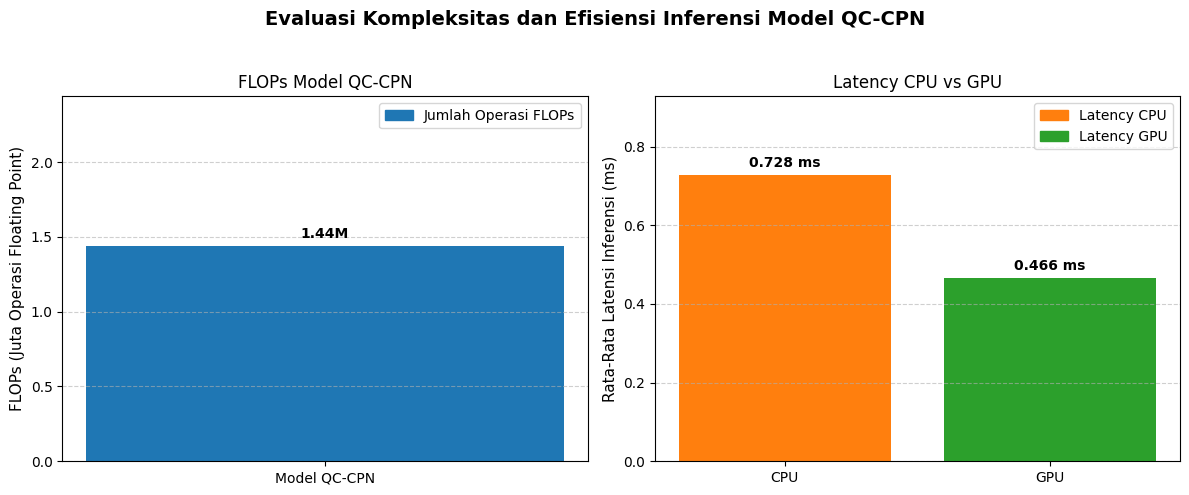

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Data hasil eksperimen
flops_million = 1.44
latency_cpu = 0.728
latency_gpu = 0.466

# Warna
colors = {
    "FLOPs": "#1f77b4",
    "CPU": "#ff7f0e",
    "GPU": "#2ca02c"
}


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Subplot 1: FLOPs ---
bars1 = ax1.bar(["Model QC-CPN"], [flops_million], color=colors["FLOPs"])
ax1.set_ylabel("FLOPs (Juta Operasi Floating Point)", fontsize=11)
ax1.set_title("FLOPs Model QC-CPN", fontsize=12)
ax1.set_ylim(0, flops_million + 1)
ax1.grid(axis='y', linestyle='--', alpha=0.6)


for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.05, f"{yval:.2f}M", ha='center', fontweight='bold')

# Legend FLOPs
flops_patch = mpatches.Patch(color=colors["FLOPs"], label="Jumlah Operasi FLOPs")
ax1.legend(handles=[flops_patch], loc='upper right')

# --- Subplot 2: Latency ---
latencies = [latency_cpu, latency_gpu]
labels = ["CPU", "GPU"]
colors_list = [colors["CPU"], colors["GPU"]]
bars2 = ax2.bar(labels, latencies, color=colors_list)
ax2.set_ylabel("Rata-Rata Latensi Inferensi (ms)", fontsize=11)
ax2.set_title("Latency CPU vs GPU", fontsize=12)
ax2.set_ylim(0, max(latencies) + 0.2)
ax2.grid(axis='y', linestyle='--', alpha=0.6)


for bar, val in zip(bars2, latencies):
    ax2.text(bar.get_x() + bar.get_width() / 2.0, val + 0.02, f"{val:.3f} ms", ha='center', fontweight='bold')

# Legend Latency
cpu_patch = mpatches.Patch(color=colors["CPU"], label="Latency CPU")
gpu_patch = mpatches.Patch(color=colors["GPU"], label="Latency GPU")
ax2.legend(handles=[cpu_patch, gpu_patch], loc='upper right')

fig.suptitle("Evaluasi Kompleksitas dan Efisiensi Inferensi Model QC-CPN", fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
